In [ ]:
#| default_exp core

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| exporti

# allows for type hinting annotations without breaking functionality
from __future__ import annotations
import matplotlib.figure

In [ ]:
#| export 
import warnings
warnings.filterwarnings('ignore')

import re
import os
import glob
import string
import datetime
import wordsegment

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('words', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

wordsegment.load()

## Utils 

In [ ]:
#| export
def file_loader(data_source:str|pd.DataFrame) -> pd.DataFrame:
    """
    Flexible file loader able to read a single file path or folder path.
    Accepts .csv and .json file format loading.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame.
        Existing dataframes are read as is.
        
        
    Returns
    -------
    df
        A single dataframe consisting of all data matching the provided file or folder path.
    
    """
    if isinstance(data_source, str):
        data_lst = glob.glob(data_source)
        dfs = []
        for x in data_lst:
            if x[-4:] == '.csv':
                dfs.append(pd.read_csv(x))
            elif x[-5:] == '.json':
                json_file = pd.read_json(x)
                if not isinstance(json_file, pd.DataFrame):
                    return json_file
                dfs.append(json_file)
        df = pd.concat(dfs).reset_index(drop=True)
    else:
        df = data_source

    return df

Providing the file loader with a specific file path outputs a single Pandas data frame generated from that data source.

In [ ]:
file_loader("data/col_test_data/toy_data_2000.csv").head(2)

,original_logtime,desc_text,food_type,PID
0,2021-05-12 02:30:00 +0000,milk,b,yrt1999
1,2021-05-12 02:45:00 +0000,some medication,m,yrt1999


The file loader can also accept string patterns to read in multiple files at once. Providing a patterened path such as yrt\*_food_data\*.csv would load all data matching this pattern. 

In [ ]:
file_loader('data/col_test_data/yrt*_food_data*.csv').head(2)

,original_logtime,desc_text,food_type,PID
0,2021-05-12 02:30:00 +0000,Milk,b,yrt1999
1,2021-05-12 02:45:00 +0000,Some Medication,m,yrt1999


It can also handle reading mixed file types. The below dataframe consists of data read from all .json and .csv files in the *data/output/* folder.

In [ ]:
file_loader('data/output/*').head(2)

,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,date,local_time,time,week_from_start,year,cleaned,day_count
0,7572733.0,alqt14018795225,150.0,Water,w,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1.0,2017.0,NaN,NaN
1,411111.0,alqt14018795225,150.0,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1.0,2017.0,NaN,NaN


In [ ]:
#| export
def find_date(data_source:str|pd.DataFrame,
              h:int = 4,
              date_col:int = 5) -> pd.Series:
    """
    Extracts date from a datetime column and after shifting datetime by 'h' hours.
    A day starts 'h' hours early if 'h' is negative, or 'h' hours later if 'h' is
    positive.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is.
    h
        Number of hours to shift the definition for 'date' by. h = 4 would shift days so that time membership
        to each date starts at 4:00 AM and ends at 3:59:59 AM the next calendar day.
    date_col
        Column number for existing datetime column in provided data source. Data exported from mCC typically
        has datetime as its 5th column.
    
    
    Returns
    -------
    date
        Series of dates.
    """
    df = file_loader(data_source)
    # fifth column of food log dataframes should represent date/time in a 24 hour system
    col = df.columns[date_col]
    if df[col].dtype == 'O':
        raise TypeError("'{}' column must be converted to datetime object".format(col))
        
    def find_date(d, h):
        if h > 0:
            if d.hour < h:
                return d.date() - pd.Timedelta('1 day')
        if h < 0:
            if d.hour+1 > (24+h):
                return d.date() + pd.Timedelta('1 day')
        return d.date()
    return df[col].apply(find_date, args=([h]))

By default, find_date expects log dates for studies to begin at 4:00 AM. To use regular calendar dates, remember to set h = 0.

In [ ]:
df = file_loader('data/test_food_details.csv')
df['original_logtime'] = pd.to_datetime(df['original_logtime'])
df['date'] = find_date(df, h = 0)
df[['original_logtime', 'date']].head(3)

,original_logtime,date
0,2017-12-08 17:30:00+00:00,2017-12-08
1,2017-12-09 00:01:00+00:00,2017-12-09
2,2017-12-09 00:58:00+00:00,2017-12-09


In this example, with log dates starting at the default value of 4 (4:00 AM), we see that two logs from very early morning on 12-09-2017 are counted as being logged on 12-08-2017 instead.

In [ ]:
df['date'] = find_date(df, h = 4)
df[['original_logtime', 'date']].head(3)

,original_logtime,date
0,2017-12-08 17:30:00+00:00,2017-12-08
1,2017-12-09 00:01:00+00:00,2017-12-08
2,2017-12-09 00:58:00+00:00,2017-12-08


Similarly, in an example where we start log days four hours earlier, the last two rows have dates that are shifted so their log date is one day later than their exact calendar datetime.

In [ ]:
df['date'] = find_date(df, h = -4)
df[['original_logtime', 'date']].head(5)

,original_logtime,date
0,2017-12-08 17:30:00+00:00,2017-12-08
1,2017-12-09 00:01:00+00:00,2017-12-09
2,2017-12-09 00:58:00+00:00,2017-12-09
3,2018-02-22 21:52:00+00:00,2018-02-23
4,2018-02-22 22:53:00+00:00,2018-02-23


In [ ]:
#| export
def find_float_time(data_source:str|pd.DataFrame,
                    h:int = 4,
                    date_col:int = 5) -> pd.Series:
    """
    Extracts time from a datetime column and after shifting datetime by 'h' hours.
    A day starts 'h' hours early if 'h' is negative, or 'h' hours later if 'h' is
    positive.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is.
    h
        Number of hours to shift the definition for 'time' by. h = 4 would allow float representations of time
        between 4 (inclusive) and 28 (exclusive), representing time that goes from 4:00 AM to 3:59:59 AM the next
        calendar day. NOTE: h value for this function should match the h value used for generating dates.
    date_col
        Column number for existing datetime column in provided data source. Data exported from mCC typically
        has datetime as its 5th column.
    
    
    Returns
    -------
    local_time
        Series of times.
    """
    df = file_loader(data_source)
    # fifth column of food log dataframes should represent date/time in a 24 hour system
    col = df.columns[date_col]
    if df[col].dtype == 'O':
        raise TypeError("'{}' column must be converted to datetime object firsly".format(col))
    local_time = df[col].apply(lambda x: pd.Timedelta(x.time().isoformat()).total_seconds() /3600.)
    if h > 0:
        local_time = np.where(local_time < h, 24+ local_time, local_time)
        # index= to prevent mistaken assignments when data source and target df have a non-trivial index
        return pd.Series(local_time, index=df.index) 
    if h < 0:
        local_time = np.where(local_time > (24+h), local_time-24., local_time)
        return pd.Series(local_time, index=df.index)
    return local_time
    

In [ ]:
df = file_loader('data/test_food_details.csv')
df['original_logtime'] = pd.to_datetime(df['original_logtime'])

By default, find_float_time expects studies to begin at 4:00 AM. To preserve regular calendar dates
use h = 0.

In [ ]:
df['float_time'] = find_float_time(df, h = 0)
df[['original_logtime', 'float_time']].head(3)

,original_logtime,float_time
0,2017-12-08 17:30:00+00:00,17.500000
1,2017-12-09 00:01:00+00:00,0.016667
2,2017-12-09 00:58:00+00:00,0.966667


Using positive values for h for both date and float time functions changes date ownership for a row based on its
original logtime. Float time should be shifted by the same h value so that times belonging to a different calendar
date can be differentiated when necessary (e.g. 2:00 AM --> 2.0, whereas 2:00 AM the next calendar day --> 26.0, for cases
where these rows should still be grouped together).

In [ ]:
df['float_time'] = find_float_time(df, h = 4)
df['date'] = find_date(df, h = 4)
df[['original_logtime','date', 'float_time']].head(3)

,original_logtime,date,float_time
0,2017-12-08 17:30:00+00:00,2017-12-08,17.500000
1,2017-12-09 00:01:00+00:00,2017-12-08,24.016667
2,2017-12-09 00:58:00+00:00,2017-12-08,24.966667


In rare cases, it may be valuable to shift date and time by negative values. In this example where a log date starts
at 8:00 PM the previous calendar day and ends at 8:00 PM the current calendar day, note that the last two rows have negative float times and their date membership is shifted one date further than their original calendar datetime.

In [ ]:
df['float_time'] = find_float_time(df, h = -4)
df['date'] = find_date(df, h = -4)
df[['original_logtime','date', 'float_time']].head(5)

,original_logtime,date,float_time
0,2017-12-08 17:30:00+00:00,2017-12-08,17.500000
1,2017-12-09 00:01:00+00:00,2017-12-09,0.016667
2,2017-12-09 00:58:00+00:00,2017-12-09,0.966667
3,2018-02-22 21:52:00+00:00,2018-02-23,-2.133333
4,2018-02-22 22:53:00+00:00,2018-02-23,-1.116667


In [ ]:
#| export
def week_from_start(data_source:str|pd.DataFrame,
                    identifier:int = 1) -> np.array:
    """
    Calculates the number of weeks between each logging entry and the first logging entry
    for each participant (unique identifier). A 'date' column must exist in the provided data source. 
    Using the provided find_date function is recommended.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.


    Returns
    -------
    count_weeks
        Array of weeks passed from minimum date.
    """
        
    df = file_loader(data_source)
    if 'date' not in df.columns:
        raise NameError("There must exist a 'date' column.")
    col = df.columns[df.columns.get_loc('date')]
    identifier = df.columns[identifier]
    # Handle week from start
    df_dic = dict(df.groupby(identifier)[col].agg(np.min))

    def count_weeks(s):
        return (s.date - df_dic[s[identifier]]).days // 7 + 1

    return df.apply(count_weeks, axis = 1)

In [ ]:
df = file_loader('data/test_food_details.csv')
df['original_logtime'] = pd.to_datetime(df['original_logtime'])

Using find_date to ensure that a date column exists in the data source is recommended. A column labeled
'date' is a requirement of this function.

In [ ]:
df['date'] = find_date(df)
df['week_from_start'] = week_from_start(df)
df[['unique_code','original_logtime','week_from_start']][2:4]

,unique_code,original_logtime,week_from_start
2,alqt14018795225,2017-12-09 00:58:00+00:00,1
3,alqt14018795225,2018-02-22 21:52:00+00:00,11


In [ ]:
#| export
def find_phase_duration(df:pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the duration (in days) of the study phase for each row.
    
    Parameters
    ----------
    df
        Participant information dataframe with columns for start and ending date for that row's study phase.
        The expected column numbers for starting and ending dates are outlined in the HOWTO document that
        accompanies TREETS.
    
    
    Returns
    -------
    df
        Provided dataframe with an additional column describing phase duration.
    """
    # column order is specified in our how-to document for data from collaborators
    start_day = df.columns[4]
    end_day = df.columns[5]
    
    # checking if type conversion from string to datetime is necessary
    if df[start_day].apply(lambda x: isinstance(x, str)).any():
        df[start_day] = pd.to_datetime(df[start_day])
    
    if df[end_day].apply(lambda x: isinstance(x, str)).any():
        df[end_day] = pd.to_datetime(df[end_day])
    
    df['phase_duration'] = df[end_day] - df[start_day] + pd.Timedelta("1 days")
    return df

In [ ]:
find_phase_duration(pd.read_excel('data/col_test_data/toy_data_17May2021.xlsx'))[['phase_duration']]

,phase_duration
0,3 days
1,4 days
2,3 days
3,4 days
4,NaT


In [ ]:
#| export
def load_food_data(data_source:str|pd.DataFrame,
                   h:int,
                   identifier:int = 1,
                   datetime_col:int = 5) -> pd.DataFrame:
    """
    Loads and processes existing logging data, adding specific datetime information in formats
    more suitable for TREETS functions.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is.
    h
        Number of hours to shift the definition of 'date' by. h = 4 would indicate that a log date begins at
        4:00 AM and ends the following calendar day at 3:59:59. Float representations of time would therefore
        go from 4.0 (inclusive) to 28.0 (exclusive) to represent 'date' membership for days shifted from their
        original calendar date.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    datetime_col
        Column number for an existing datetime column in provided data source. Data exported from mCC typically
        has datetime as its 5th column.
    
    
    Returns
    -------
    food_all
        Processed dataframe with additional date, flat time, and week from start columns.
    """
    food_all = file_loader(data_source)
    # identifier column(s) should be 0 and 1, with 1 being study specific
    identifier = food_all.columns[identifier]
    # fifth column of food log dataframes should represent date/time in a 24 hour system
    datetime_col = food_all.columns[datetime_col]
        
    try:
        food_all = food_all.drop(columns = ['foodimage_file_name'])
    except KeyError:
        pass
    
    def handle_time(s):
        """
        helper function to get rid of am/pm in the end of each time string
        """
        tmp_s = s.replace('p.m.', '').replace('a.m.', '')
        try:
            return pd.to_datetime(' '.join(tmp_s.split()[:2]) )
        except:
            try:
                if int(tmp_s.split()[1][:2]) > 12:
                    tmp_s = s.replace('p.m.', '').replace('a.m.', '').replace('PM', '').replace('pm', '')
                return pd.to_datetime(' '.join(tmp_s.split()[:2]) )
            except:
                return np.nan

    food_all[datetime_col] = food_all[datetime_col].apply(handle_time)
    food_all = food_all.dropna().reset_index(drop = True)
    food_all['date'] = find_date(food_all, h)
    
    # Handle the time - Time in floating point format
    
    food_all['float_time'] = find_float_time(food_all, h)
    
    # Handle the time - Time in Datetime object format
    food_all['time'] = pd.DatetimeIndex(food_all[datetime_col]).time
    
    # Handle week from start
    food_all['week_from_start'] = week_from_start(food_all)
    
    food_all['year'] = food_all.date.apply(lambda d: d.year)
    
    return food_all

In [ ]:
load_food_data('data/test_food_details.csv', h = 4).head(2)

,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,date,float_time,time,week_from_start,year
0,7572733,alqt14018795225,150,Water,w,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1,2017
1,411111,alqt14018795225,150,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1,2017


In [ ]:
#| export
def in_good_logging_day(data_source:str|pd.DataFrame,
                        min_log_num:int = 2,
                        min_separation:int = 5,
                        identifier:int = 1,
                        date_col:int = 6,
                        time_col:int = 7) -> np.array:
    """
    Calculates if each row is considered to be within a 'good logging day'. A log day is considered 'good' if there 
    are more than the minimum number of required logs, with a specified hour separation between the first and last
    log for that log date. It is recommended that you use find_date and find_float_time to generate necessary date and
    time columns for this function.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is.
    
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.

    date_col
        Column number for an existing date column in provided data source. 
    
    time_col
        Column number for an existing time column in provided data source. 
    
    
    Returns
    -------
    in_good_logging_day
        Boolean array describing whether each row is a 'good' logging day.
    """
    def adherent(s):
        if len(s.values) >= min_log_num and (max(s.values) - min(s.values)) >= min_separation:
            return True
        else:
            return False
        
    df = file_loader(data_source)
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
        
    adherent_dict = dict(df.groupby([identifier, date_col])[time_col].agg(adherent))

    return df.apply(lambda x: adherent_dict[(x[identifier], x.date)], axis = 1)

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
df['in_good_logging_day'] = in_good_logging_day(df)
df.head(2)

,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,date,float_time,time,week_from_start,year,in_good_logging_day
0,7572733,alqt14018795225,150,Water,w,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1,2017,True
1,411111,alqt14018795225,150,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1,2017,True


In [ ]:
#| export
class FoodParser:
    """
    Food parser handles taking unprocessed food log entries and adding relevant
    information from a pre-made dictionary. This includes matching unprocessed terms to
    their likely matches, adding food type and other identifying information.
    """

    def __init__(self):
        """Initializes food parser object."""
        # read in manually annotated file
        parser_keys_df = pd.read_csv("data/09_14_2023_parser_keys.csv")
        all_gram_set, food_type_dict, food2tags = self.process_parser_keys_df(
            parser_keys_df
        )
        correction_dic = pd.read_json("data/correction_dic.json", typ="series")
        
        self.all_gram_set = all_gram_set
        self.food_type_dict = food_type_dict
        self._food_phrases = np.unique(
            [
                word
                for key in self.food_type_dict
                for word in key.split()
                if self.food_type_dict[key] in ["f", "b", "m"] and len(word) > 2
            ]
        )
        self.correction_dic = correction_dic
        self.food2tags = food2tags

        # Load common stop words and nlp type objects
        self.wnl = WordNetLemmatizer()

        self.stop_words = stopwords.words("english")
        self.stop_words.remove("out")  # since pre work out is a valid beverage name
        self.stop_words.remove("no")
        self.stop_words.remove("not")
        self.stop_words.remove("and")
        self.stop_words.remove("m")
        self.stop_words.remove("of")
        # preventing common vitamins from being removed
        self.stop_words.remove("d")

    @staticmethod
    def process_parser_keys_df(parser_keys_df):
        """Takes a dataframe of parser keys and processes gram sets and
        food type information.

        Parameters
        ----------
        parser_keys_df: pd.DataFrame
            Dataframe of parser keys.

        Returns
        -------
        all_gram_set: list
            List of sets where each set corresponds to all (n-grams for n in range 1-6)

        food_type_dict: dict
            Dictionary of gram key and food type pairings where gram key
            is the food (e.g. 'milk') and the value is the type (e.g. 'b')

        food2tags: dict
            Dictionary of gram key and corresponding tags. (e.g. key = 'vodka'
            with tags 'alcohol', 'liquor', etc..)
        """
        # f = food, b = beverage, m = medicine, w = water
        # below are the possible valid item types
        parser_keys_df = parser_keys_df.query(
            'food_type in ["f", "b", "m", "w", "modifier", "general", "stopword", "selfcare"]'
        ).reset_index(drop=True)

        # creates an all_gram_set to store n-grams (e.g. 1-grams, 2-grams, etc.)
        all_gram_set = []
        for i in range(1, 5 + 1):
            all_gram_set.append(
                set(parser_keys_df.query("gram_type == " + str(i))["gram_key"].values)
            )

        # pair gram key and corresponding food type for items as a dictionary
        food_type_dict = dict(
            zip(parser_keys_df["gram_key"].values, parser_keys_df["food_type"].values)
        )

        # find all relevant tags
        def find_all_tags(df):
            """Finds tags for each 'food' item.

            Parameters
            -----------
            df: DataFrame
                Dataframe with food tag columns (e.g. tag1)
            """
            tags = []
            for i in range(1, 8):
                # expects column names of the format 'tag#'
                if not isinstance(df["tag" + str(i)], str) and np.isnan(
                    df["tag" + str(i)]
                ):
                    # append empty tag if tag doesn't exist
                    # forced food2tags to have length 8 + can restore tags
                    # in order with a dictionary
                    tags.append("")
                    continue
                # append existing tags
                tags.append(df["tag" + str(i)])
            return tags

        # pair gram_keys (food names) and their corresponding list of informative tags
        food2tags = dict(
            zip(
                parser_keys_df["gram_key"].values,
                parser_keys_df.apply(find_all_tags, axis=1),
            )
        )
        return all_gram_set, food_type_dict, food2tags

    ########## Pre-Processing ##########

    # Function for removing numbers
    @staticmethod
    def handle_numbers(text):
        """Removes numeric characters from text.

        Parameters
        ----------
        text: str
            Text to be cleaned

        Returns
        -------
        text: str
            Text with numbers removed.
        """
        # regex pattern removes all decimal numbers
        text = re.sub("[0-9]+\.[0-9]+", "", text)
        # retaining common items (h2o, co2, v8, ag1)
        if any(sub in text for sub in ["v8", "h2", "ag1", "co2", "0z"]):
            # regex pattern strips any numbers not immediately preceded or followed by a letter
            text = re.sub(r"(?<![a-zA-Z])\d+(?![a-zA-Z])", "", text)
        else:
            # regex pattern strips all whole numbers
            text = re.sub("[0-9+]", "", text)
        # regex pattern truncates any duplicate whitespace (e.g. "  " becomes  " ")
        text = re.sub("\s\s+", " ", text)
        return text

    # Function for removing punctuation
    @staticmethod
    def drop_punc(text):
        """
        Removes punctuation from text.

         Parameters
        ----------
        text: str
            Text to be cleaned

        Returns
        -------
        text: str
            Text with punctuation removed.
        """
        return re.sub("[%s]" % re.escape(string.punctuation), " ", text)

    # Remove normal stopwords
    def remove_stop(self, text):
        """
        Removes english stop words defined by nltk (e.g. 'the') from text.

         Parameters
        ----------
        text: str
            Text to be cleaned

        Returns
        -------
        text: str
            Text with stop words removed.
        """
        return " ".join([word for word in text.split() if word not in self.stop_words])

    def pre_processing(self, text):
        """
        Handles text cleaning overall.

        Parameters
        ----------
        text: str
            Text to be pre-processed/cleaned.

        Returns
        --------
        text: str
            Cleaned text.
        """
        return self.remove_stop(
            self.handle_numbers(self.drop_punc(text.lower()))
        ).strip()

    ########## Handle Format ##########
    @staticmethod
    def handle_front_mixing(sent, front_mixed_tokens):
        """
        Handles cleaned front mixed tokens, which seem to be some sort of digit/numerical.
        Potentially dealing with cleaning out item quantities? (e.g. 12oz?)

        Parameters
        ----------
        sent: str
            Phrase/sentence describing a food item.

        front_mixed_tokens: list
            List of front mixed tokens (I think these are supposed to be amount tokens),
            e.g. 12oz

        Returns
        --------
        sent: str
            Original sentence with any front mixed tokens cleaned (e.g. 12oz --> 12 oz).
        """
        cleaned_tokens = []
        for t in sent.split():
            if t in front_mixed_tokens:
                number = re.findall("\d+[xX]*", t)[0]
                for t_0 in t.replace(number, number + " ").split():
                    cleaned_tokens.append(t_0)
            else:
                cleaned_tokens.append(t)
        return " ".join(cleaned_tokens)

    @staticmethod
    def handle_x2(sent, times_x_tokens):
        """
        Handles variations in spacing or capitalization for the same token.
        e.g. ('x2' vs 'X2' vs 'X 2' vs 'X 2')

        Parameters
        ----------
        sent: str
            Phrase/sentence describing a food item.

        times_x_tokens: list of 'times x' tokens to be dealt with.

        Returns
        --------
        sent: str
            Original sentence with any 'times x' variations cleaned.
        """
        for token in times_x_tokens:
            sent = sent.replace(token, " " + token.replace(" ", "").lower() + " ")

        return " ".join([s for s in sent.split() if s != ""]).strip()

    def clean_format(self, sent):
        """
        Cleans text of any amount indications. Specifically deals with
        front mixing (amount of an item noted at the front of the string)
        and 'times x' where multiple of an item is recorded in the style of
        (item x 2) or some variation of that.

        Parameters
        ----------
        sent: str
            Sentence to be cleaned.

        Returns
        -------
        sent: str
            Sentence after all amount/format style cleaning applied.
        """
        # Problem 1: 'front mixing'
        front_mixed_tokens = re.findall("\d+[^\sxX]+", sent)
        if len(front_mixed_tokens) != 0:
            sent = self.handle_front_mixing(sent, front_mixed_tokens)

        # Problem 2: 'x2', 'X2', 'X 2', 'x 2'
        times_x_tokens = re.findall("[xX]\s*?\d", sent)
        if len(times_x_tokens) != 0:
            sent = self.handle_x2(sent, times_x_tokens)
        return sent

    ########## Handle Typos ##########

    def fix_spelling(self, entry):
        """Corrects spelling mistakes.

        Parameters
        ----------
        entry: str
            String entry to be corrected.

        Returns
        -------
        entry: str
            Original entry with spelling corrections applied.
        """
        result = []

        # if entry is recognized keep it
        if entry in self.food_type_dict:
            return entry
        # try looking for entry in correction dictionary
        if entry in self.correction_dic:
            return " ".join(
                [self.wnl.lemmatize(i) for i in self.correction_dic[entry].split()]
            )
        # try lemmatized version of whole entry
        if self.wnl.lemmatize(entry) in self.food_type_dict:
            return self.wnl.lemmatize(entry)
        # try correcting individual tokens within entry phrase
        for token in entry.split():
            # try lemmatized version of the token
            lem_token = self.wnl.lemmatize(token)
            if (lem_token in self._food_phrases) or (lem_token in self.food_type_dict):
                token = lem_token
            # try looking for token in correction dictionary
            elif token in self.correction_dic:
                token = " ".join(
                    [self.wnl.lemmatize(i) for i in self.correction_dic[token].split()]
                )
            # check if token is incorrectly joined
            # (e.g. blueberrymuffin instead of blueberry muffin)
            elif token not in self._food_phrases:
                temp = []
                token_alt = wordsegment.segment(token)
                for word in token_alt:
                    if self.wnl.lemmatize(word) in self._food_phrases:
                        temp += [word]
                    # check if split word needs spell correction
                    elif (
                        word in self.correction_dic
                        and self.correction_dic[word] in self._food_phrases
                    ):
                        temp += [self.correction_dic[word]]
                # if there are any newly corrected/unjoined tokens add them back to the result
                if len(temp) > 1:
                    token = " ".join([self.wnl.lemmatize(i) for i in temp])
            result.append(token.strip())
        return " ".join(result).strip()

    def handle_all_cleaning(self, entry):
        """
        Performs all types of text cleaning.

        Parameters
        ----------
        entry: str
            String entry to be corrected.

        Returns
        -------
        entry: str
            String entry with all forms of pre-processing and cleaning
            applied.
        """
        entry = self.pre_processing(entry)
        entry = self.clean_format(entry)
        entry = self.fix_spelling(entry)
        entry = re.sub("\s\s+", " ", entry)
        return entry

    ########## Handle Gram Matching ##########
    @staticmethod
    def parse_single_gram(gram_length, gram_set, gram_lst, sentence_tag):
        """
        Parses a single gram, combining words as necessary for the proper gram
        length (e.g. grape juice is a bigram) and then adding any new words
        to a food list.

        Parameters
        ----------
        gram_length: int
            Length of gram to look for (e.g. 2 --> bigram).

        gram_set: list
            Existing gram set.

        gram_list: list
            List of grams to check for entry into the gram set.

        sentence tag: list
            List of tags for the sentence?

        Returns
        -------
            food_lst: list
                All unique items for the given gram being parsed.
        """
        food_lst = []
        for i, gram in enumerate(gram_lst):
            # if not a unigram, combine the words from the gram list into a
            # gram string
            if gram_length > 1:
                curr_word = " ".join(gram)
            else:
                curr_word = gram
            if (
                curr_word in gram_set
                and sum([t != "Unknown" for t in sentence_tag[i : i + gram_length]])
                == 0
            ):
                # add any first occurance of a food to the food list
                sentence_tag[i : i + gram_length] = str(gram_length)
                food_lst.append(curr_word)
        return food_lst

    def parse_single_entry(self, entry, return_sentence_tag=False):
        """
        Handles pre-processing, cleaning, and gram processing for a single entry.

        Parameters
        ----------
        entry: str
            Entry to be processed

        Returns
        -------
        All grams of length 5 or under for the particular entry.
        """
        cleaned = self.handle_all_cleaning(entry)

        # Create tokens and n-grams
        tokens = nltk.word_tokenize(cleaned)
        bigram = list(nltk.ngrams(tokens, 2)) if len(tokens) > 1 else None
        trigram = list(nltk.ngrams(tokens, 3)) if len(tokens) > 2 else None
        quadgram = list(nltk.ngrams(tokens, 4)) if len(tokens) > 3 else None
        pentagram = list(nltk.ngrams(tokens, 5)) if len(tokens) > 4 else None
        all_gram_lst = [tokens, bigram, trigram, quadgram, pentagram]

        # Create an array of tags
        sentence_tag = np.array(["Unknown"] * len(tokens))

        all_food = []
        for gram_length in [5, 4, 3, 2, 1]:
            if len(tokens) < gram_length:
                continue
            tmp_food_lst = self.parse_single_gram(
                gram_length,
                self.all_gram_set[gram_length - 1],
                all_gram_lst[gram_length - 1],
                sentence_tag,
            )
            all_food += tmp_food_lst
        if return_sentence_tag:
            return all_food, sentence_tag
        return all_food

    def parse_food(self, series, calc_unknowns = False):
        """
        Parses a series of single food entries.

        Parameters
        ----------
        series: list or series of str
            Food entries to be parsed.
        
        calc_unknowns: bool
            If true, includes unknown token information in return. Default is false.
            
        Returns
        -------
        Series of parsed food items.
        """
        def parse(x, calc_unknowns = calc_unknowns):
            return self._parse_food(x, calc_unknowns)
        vec = np.vectorize(parse)
        return vec(series)

    def _parse_food(self, entry, calc_unknowns = False):
        """
        Parses a single food entry.

        Parameters
        ----------
        entry: str
            Food entry to be parsed.
        
        calc_unknowns: bool
            If true, includes unknown token information in return. Default is false.
            
        Returns
        -------
        A single parsed food entry.
        """
        result = []
        unknown_tokens = []
        num_unknown = 0
        num_token = 0

        for word in entry.split(","):
            # previous versions of this if statement assume that
            # return_sentence_tag is True and will actually break
            # if the default parameters are used
            all_food, sentence_tag = self.parse_single_entry(word, True)
            result += all_food
            if calc_unknowns:
                if sentence_tag is not None and len(sentence_tag) > 0:
                    num_unknown += sum(np.array(sentence_tag) == "Unknown")
                    num_token += len(sentence_tag)
                    cleaned = nltk.word_tokenize(self.handle_all_cleaning(word))

                    # Return uncaught tokens, grouped into sub-sections
                    tmp_unknown = ""
                    for i, tag in enumerate(sentence_tag):
                        if tag == "Unknown":
                            tmp_unknown += " " + cleaned[i]
                            if i == len(sentence_tag) - 1:
                                unknown_tokens.append(tmp_unknown.strip())
                        elif tmp_unknown != "":
                            unknown_tokens.append(tmp_unknown.strip())
                            tmp_unknown = ""
        if calc_unknowns:
            return np.array(
                [result, num_token, num_unknown, unknown_tokens], dtype = "object"
            )
            
        return np.array(result, dtype = "object")

    def find_food_type(self, food):
        """
        Finds corresponding food-item type for a given food. Types include
        beverage, water, food, medicine.

        Parameters
        ----------
        food: str
            Food to find type for

        Returns
        -------
        Corresponding food type abbrevation or 'u' if not found.
        """
        if food in self.food_type_dict:
            return self.food_type_dict[food]
        # shorthand for unknown
        return "u"

    ################# DataFrame Functions #################
    def expand_entries(self, df):
        """
        Creates an 'exploded' version of the given dataframe, expanding entries
        from within list-style 'desc_text' column entries such that each
        entry in a list has its own corresponding row.

        Parameters
        ----------
        df: pd.Dataframe
            Dataframe to be expanded.

        Returns
        -------
        df: pd.Dataframe
            Expanded dataframe.
        """
        assert "desc_text" in df.columns, '[ERROR] Required a column of "desc_text".'
        df = df.copy()
        df["desc_text"] = df["desc_text"].str.split(",")
        df = df.explode("desc_text")
        # remove entries that are only spaces or digits (entries with no alphabetical characters)
        df = df[~df["desc_text"].str.isspace()]
        df = df[~df["desc_text"].str.isdigit()]
        return df


In [ ]:
#| export 
def clean_loggings(data_source:str|pd.DataFrame,
                   identifier:int = 1):
    """
    Cleans and corrects all logging text entries.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column
    
    
    Returns
    -------
    df_parsed
        Dataframe with an additional column containing cleaned and typo corrected item entries.

    """

    df = file_loader(data_source)
    identifier = df.columns[identifier]
    text_col = df.columns[df.columns.get_loc('desc_text')]
    
    # initialize food parser instance
    fp = FoodParser()
    
    # parse food
    parsed = fp.parse_food(df["desc_text"])
    df_parsed = pd.DataFrame({
    identifier: df[identifier],
    text_col: df[text_col],
    'cleaned': parsed
    })
    
    return df_parsed

Text descriptions of food items are cleaned using a built-in dictionary of common typos and corrections for each phrase. Phrases are then matched using a dictionary of known n-gram item names. The resulting item(s) are provided as a list.

In [ ]:
clean_loggings('data/output/public.json').head(3)

,unique_code,desc_text,cleaned
0,alqt14018795225,Water,[water]
1,alqt14018795225,Coffee White,"[coffee, white]"
2,alqt14018795225,Salad,[salad]


In [ ]:
#| export
def get_types(data_source:str|pd.DataFrame,
              food_type:str|list) -> pd.DataFrame:
    """
    Filters logs for only logs of specified type(s).
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. A column 'food_type' is required to be within the data.
    
    food_type
        A single food type, or list of food types. Valid types are 'w': water, 'b': beverage,
        'f': food, and 'm': medication.
    
    Returns
    -------
    filtered
        Dataframe filtered for only logs of specific type(s).        
    """
    
    df = file_loader(data_source)
        
    if len(food_type) == 0:
        return df
    
    if len(food_type) == 1:
        if food_type[0] not in ['w', 'b', 'f', 'm']:
            raise Exception("not a valid logging type")
        filtered = df[df['food_type']==food_type[0]]
    else:  
        filtered = df[df['food_type'].isin(food_type)]
        
    
    return filtered

In [ ]:
get_types('data/output/baseline.json',['w', 'f'])[['unique_code','desc_text','food_type']].head(3)

,unique_code,desc_text,food_type
0,alqt14018795225,Water,w
2,alqt14018795225,Salad,f
3,alqt78896444285,Water,w


In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
get_types(df, ['m'])[['unique_code','desc_text','food_type']].head(3)

,unique_code,desc_text,food_type
323,alqt14018795225,Caffeine,m
361,alqt14018795225,Caffeine,m
420,alqt14018795225,Caffeine,m


In [ ]:
#| export
def count_caloric_entries(df:pd.DataFrame) -> int:
    """
    Counts the number of food ('f') and beverage ('b') loggings.
    
    Parameters
    ----------
    df
        Dataframe of food logging data.
        
    
    Returns
    -------
    num_caloric_entries
        Number of caloric (food or beverage) entries found.
    """
    if 'food_type' not in df.columns:
        raise Exception("'food_type' column must exist in the dataframe.")
        
    food_type_col = df.columns[df.columns.get_loc('food_type')]
    num_caloric = df[df[food_type_col].isin(['f','b'])].shape[0]
    
    return num_caloric

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
count_caloric_entries(df)

4603

In [ ]:
#| export
def mean_daily_eating_duration(df:pd.DataFrame,
                               date_col:int = 6,
                               time_col:int = 7) -> float:
    """
    Calculates mean daily eating window by taking the average of each day's eating window. An eating window
    is defined as the duration of time between first and last caloric (food and beverage) intake. It is
    recommended that you use find_date and find_float_time to generate necessary date and time columns for this
    function. 
    
    Parameters
    ----------
    df
        Dataframe of food logging data. A column for 'food_type' must exist within the data.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
        
        
    Returns
    -------
    mean_daily_eating_duration
        Float representation of average daily eating window duration.
    """
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]

    df = df[df['food_type'].isin(['f','b'])]
    breakfast_time = df.groupby(date_col)[time_col].agg(min)
    dinner_time = df.groupby(date_col)[time_col].agg(max)
    return (dinner_time - breakfast_time).mean()

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
mean_daily_eating_duration(df)

14.038679245283017

In [ ]:
#| export
def std_daily_eating_duration(df:pd.DataFrame,
                              date_col:int = 6,
                              time_col:int = 7) -> float:
    """
    Calculates the standard deviation of the daily eating window. An eating window
    is defined as the duration of time between first and last caloric (food and beverage) intake. 
    It is recommended that you use find_date and find_float_time to generate necessary date and time
    columns for this function. 
    
    Parameters
    ----------
    df
        Dataframe of food logging data. A column for 'food_type' must exist within the data.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
        
        
    Returns
    -------
    std_daily_eating_duration
        Float representation of the standard deviation of daily eating window duration.
    """
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
        
    df = df[df['food_type'].isin(['f','b'])]
    breakfast_time = df.groupby(date_col)[time_col].agg(min)
    dinner_time = df.groupby(date_col)[time_col].agg(max)

    return (dinner_time - breakfast_time).std()

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
std_daily_eating_duration(df)

7.018679942775867

In [ ]:
#| export
def earliest_entry(df:pd.DataFrame,
                   time_col:int = 7) -> float:
    """
    Calculates the earliest recorded caloric (food or beverage) entry. It is recommended that 
    you use find_float_time to generate necessary the time column for this function. 
    
    Parameters
    ----------
    df
        Dataframe of food logging data. A column for 'food_type' must exist within the data. 
    time_col
        Column number for an existing time column in provided data source.
        
        
    Returns
    -------
    earliest_entry
        Float representation of the earliest logtime on any date.
    """
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    df = get_types(df, ['f', 'b'])
    
    return df[time_col].min()

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
earliest_entry(df)

4.0

In [ ]:
#| export
def mean_first_cal(df:pd.DataFrame,
                   date_col:int = 6,
                   time_col:int = 7) -> float:
    """
    Calculates the average time of first caloric intake. It is recommended that you use
    find_date and find_float_time to generate necessary date and time columns for this
    function. 
    
    Parameters
    ----------
    df
        Dataframe of food logging data. A column for 'food_type' must exist within the data.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
        
        
    Returns
    -------
    mean_first_cal
        Float representation of average first caloric entry time. 
    """
    
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
    
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    
    return df.groupby([date_col])[time_col].min().mean()

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
mean_first_cal(df)

8.335744234800838

In [ ]:
# find the average mean first cal time for each participant
df.groupby(['unique_code']).agg(mean_first_cal, date_col = 6, time_col = 7).iloc[:,0]

unique_code
alqt1148284857      7.821795
alqt14018795225     7.525781
alqt16675467779     5.656757
alqt21525720972    11.241486
alqt45631586569    14.690558
alqt5833085442      9.170455
alqt62359040167     7.252137
alqt6695047873      7.763008
alqt78896444285     5.259770
alqt8668165687      8.256569
Name: ID, dtype: float64

In [ ]:
#| export
def std_first_cal(df:pd.DataFrame,
                  date_col:int = 6,
                  time_col:int = 7) -> float:
    """
    Calculates the standard deviation for time of first caloric intake. It is recommended that
    you use find_date and find_float_time to generate necessary date and time columns for this
    function. 
    
    Parameters
    ----------
    df
        Dataframe of food logging data. A column for 'food_type' must exist within the data.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
        
        
    Returns
    -------
    std_first_cal
        Float representation of the standard deviation of first caloric entry time. 
    """
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
    
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    return df.groupby([date_col])[time_col].min().std()

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
std_first_cal(df)

4.488379313189289

In [ ]:
#| export
def mean_last_cal(df:pd.DataFrame,
                  date_col:int = 6,
                  time_col:int = 7) -> float:
    """
    Calculates the average time of last caloric intake. It is recommended that you use
    find_date and find_float_time to generate necessary date and time columns for this
    function. 
    
    Parameters
    ----------
    df
        Dataframe of food logging data. A column for 'food_type' must exist within the data.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
        
        
    Returns
    -------
    mean_last_cal
        Float representation of average last caloric entry time.
    """
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[6]
    
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[7]
    
    return df.groupby([date_col])[time_col].max().mean()

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
mean_last_cal(df)

23.88763102725367

In [ ]:
#| export
def std_last_cal(df:pd.DataFrame,
                 date_col:int = 6,
                 time_col:int = 7) -> float:
    """
    Calculates the standard deviation for time of last caloric intake. It is recommended that
    you use find_date and find_float_time to generate necessary date and time columns for this
    function. 
    
    Parameters
    ----------
    df
        Dataframe of food logging data. A column for 'food_type' must exist within the data.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
        
        
    Returns
    -------
    std_last_cal
        Float representation of the standard deviation of last caloric entry time. 
    """
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
    
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    return df.groupby([date_col])[time_col].max().std()

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
std_last_cal(df, 'date', 'float_time')

4.081319697979822

In [ ]:
#| export
def logging_day_counts(df:pd.DataFrame) -> int:
    """
    Calculates the number of days that contain any logs. It is recommended that
    you use find_date to generate the necessary date column for this
    function. 
    
    Parameters
    ----------
    df
        Dataframe of food logging data. A column for 'date' must exist
        within the data.
    
    Returns
    -------
    logging_day_counts
        Number of days with at least one log on that day.
    """
    date_col = df.columns[df.columns.get_loc('date')]
    return df[date_col].nunique()

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
logging_day_counts(df)

636

In [ ]:
#| export
def find_missing_logging_days(df:pd.DataFrame,
                              start_date:datetime.date = "not_defined",
                              end_date:datetime.date = "not_defined"):
    """
    Finds days that have no log entries between a start (inclusive) and end date (inclusive).
    It is recommended that you use find_date to generate the necessary date column for this
    function. 
     
    Parameters
    ----------
    df
        Dataframe of food logging data.
    start_date
        Starting date for missing day evaluation. By default the earliest date in the data will be used.
    end_date
        Ending date for missing day evaluation. By default the latest date in the data will be used.
    
    
    Returns
    -------
    missing_days
        List of days within the given timeframe that have no log entries.
    """
    
    # if start_date or end_date is missing, return nan
    # intended behavior for participants when their study phase is ongoing
    if pd.isnull(start_date) or pd.isnull(end_date):
        return np.nan
    
    # if there is no input on start_date or end_date, use earliest date and latest date
    if start_date == "not_defined":
        start_date = df['date'].min()
    if end_date == "not_defined":
        end_date = df['date'].max()
        
    df = df[(df['date']>=start_date) & (df['date']<=end_date)]
    
    # get all the dates between two dates
    missing_days = []
    for x in pd.date_range(start_date, end_date, freq='d'):
         if x not in df['date'].unique():
                missing_days.append(x.date())
    
    return missing_days

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
find_missing_logging_days(df, datetime.date(2017, 12, 7), datetime.date(2017, 12, 10))

[datetime.date(2017, 12, 7),
 datetime.date(2017, 12, 8),
 datetime.date(2017, 12, 9),
 datetime.date(2017, 12, 10)]

In [ ]:
#| export
def good_lwa_day_counts(df: pd.DataFrame,
                        window_start:datetime.time,
                        window_end:datetime.time,
                        min_log_num:int = 2,
                        min_separation:int = 5,
                        buffer_time:str = '15 minutes',
                        h:int = 4,
                        start_date:datetime.date = "not_defined",
                        end_date:datetime.date = "not_defined",
                        time_col:int = 7):
    """
    Calculates the number of 'good' logging days, 'good' window days, 'outside' window days and adherent days.
    
    Parameters
    ----------
    df
        Dataframe of food logging data.
    window_start
        Starting time for a time restriction window.
    window_end
        Ending time for a time restriction window.
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    buffer_time
        pd.Timedelta parsable string, representing 'wiggle room' for adherence.
    h
        Number of hours to shift the definition of 'date' by. h = 4 would indicate that a log date begins at
        4:00 AM and ends the following calendar day at 3:59:59. Float representations of time would therefore
        go from 4.0 (inclusive) to 28.0 (exclusive) to represent 'date' membership for days shifted from their
        original calendar date.
    start_date
        Starting date for missing day evaluation. By default the earliest date in the data will be used.
    end_date
        Ending date for missing day evaluation. By default the latest date in the data will be used.
    time_col
        Column number for an existing time column in provided data source.
        
        
    Returns
    -------
    rows: list
        List containing number of 'good' logging days, 'good' window days, 'outside' window days, and adherent days.
    bad_dates: list
        List of three lists. The lists contains dates that are not considered 'good' logging days, 'good' window days,
        or adherent days (in that order).
    """
    # check for treets created float time column, otherwise default to expected column number
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    # if start_date or end_Date is missing, return nan
    # intended behavior for participants when their study phase is ongoing
    if pd.isnull(start_date) or pd.isnull(end_date):
        return [np.nan, np.nan, np.nan, np.nan], [[],[],[]]
    
    # if there is no input on start_date or end_date, use earliest date and latest date
    if start_date == "not_defined":
        start_date = df['date'].min()
    if end_date == "not_defined":
        end_date = df['date'].max()
    
    # if window start or window end are nan, make the windows the same as control's window time.
    if pd.isnull(window_start):
        window_start = datetime.time(0,0)
    if pd.isnull(window_end):
        window_end = datetime.time(23,59)

    # helper function to determine a good logging
    def good_logging(local_time_series):
        return len(local_time_series.values) >= min_log_num and (max(local_time_series.values) - min(local_time_series.values)) >= min_separation
   
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    df = df[df['food_type'].isin(['f','b'])]
    df['original_logtime'] = pd.to_datetime(df['original_logtime']).dt.tz_localize(None)

    buffer_time = pd.Timedelta(buffer_time).total_seconds()/3600.

    in_window_count = []
    daily_count = []
    good_logging_count = []
    cur_dates = df['date'].sort_values(ascending = True).unique()
    for aday in cur_dates:
        window_start_daily = window_start.hour + window_start.minute / 60 - buffer_time
        window_end_daily = window_end.hour + window_end.minute / 60 + buffer_time
        tmp = df[df['date'] == aday]
        if (window_start == datetime.time(0,0)) and (window_end == datetime.time(23,59)):
            in_window_count.append(tmp[(tmp[time_col] >= window_start_daily + h) & (tmp[time_col] <= window_end_daily + h)].shape[0])
        else:
            in_window_count.append(tmp[(tmp[time_col] >= window_start_daily) & (tmp[time_col] <= window_end_daily)].shape[0])
        daily_count.append(df[df['date'] == aday].shape[0])
        good_logging_count.append(good_logging(df[df['date'] == aday][time_col]))

    in_window_count = np.array(in_window_count)
    daily_count = np.array(daily_count)
    good_logging_count = np.array(good_logging_count)
    good_logging_by_date = [cur_dates[i] for i, x in enumerate(good_logging_count) if not x]

    good_window_days = (in_window_count==daily_count)
    good_window_day_counts = good_window_days.sum()
    good_window_by_date = [cur_dates[i] for i, x in enumerate(good_window_days) if not x]
    
    outside_window_days = in_window_count.size - good_window_days.sum()
    good_logging_days = good_logging_count.sum()
    if good_logging_count.size == 0:
        adherent_day_counts = 0
        adherent_days_by_date = []
    else:
        adherent_days = (good_logging_count & (in_window_count == daily_count))
        adherent_days_by_date = [cur_dates[i] for i, x in enumerate(adherent_days) if not x]
        adherent_day_counts = adherent_days.sum()
    
    rows = [good_logging_days, good_window_day_counts, outside_window_days, adherent_day_counts]
    bad_dates = [good_logging_by_date, good_window_by_date, adherent_days_by_date]

    return rows, bad_dates

The main use of this function is to calculate window and logging adherence. These are represented as 'good' (valid)
logging days, 'good' window days, 'outside' (invalid) window days, and adherent days.

The definition of each is:

1. 'Good' Logging Day

    - A day with at least a specified minimum number of caloric (food or beverage) logs with a minimum specified number of hours between the first and last log for that day.
    
1. 'Good' Window Day
    - A day where all food loggings are within the participant's assigned eating restriction window.
        
1. Adherent Day

    - A day that is both a 'good' logging day and a 'good' window day.

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
dates, bad_dates = good_lwa_day_counts(df, datetime.time(8,0,0), datetime.time(23,59,59))
dates

[554, 166, 470, 97]

The second product of this function is three lists that outline which days are not compliant with one of the definitions above. The first list (index 0) consists of dates that are not 'good' logging days, the second contains days that are not 'good' window days. The final list consists of dates that are not adherent (neither 'good' window nor 'good' logging dates)

In [ ]:
bad_dates[0][:5]

[datetime.date(2017, 12, 8),
 datetime.date(2018, 3, 14),
 datetime.date(2018, 4, 18),
 datetime.date(2018, 4, 20),
 datetime.date(2018, 6, 25)]

## Experiment Design

In [ ]:
#| export
def filtering_usable_data(df:pd.DataFrame,
                          num_items:int,
                          num_days:int,
                          identifier:int = 1,
                          date_col:int = 6):
    """
    Filters data for only users who's data satisfies the minimum number of days and logs.
    It is recommended that you use find_date to generate the necessary date column for this
    function. 
    
    Parameters
    ----------
    df
        Dataframe of food logging data. A column 'desc_text', typically found in mCC data
        is required.
    num_items
        Minimum number of logs required to pass the filter
    num_days
        Minimum number of unique logging days required to pass the filter.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    
    
    Returns
    -------
    df_usable: pd.DataFrame
        Data filtered to only include data from participants that have passed filtering criteria.
    set_usable: set
        Set of participants that passed filtering criteria.
    """
    print(' => filtering_usable_data()')
    print('  => using the following criteria:', num_items, 'items and', num_days, 'days.')
    
    identifier = df.columns[1]
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]

    # Item logged
    log_item_count = df.groupby(identifier).agg('count')[['desc_text']].rename(columns = {'desc_text': 'Total Logged'})

    # Day counts
    log_days_count = df[[identifier, date_col]]\
        .drop_duplicates().groupby(identifier).agg('count').rename(columns = {date_col: 'Day Count'})

    item_count_passed = set(log_item_count[log_item_count['Total Logged'] >= num_items].index)
    day_count_passed = set(log_days_count[log_days_count['Day Count'] >= num_days].index)

    print('  => # of users pass the criteria:', end = ' ')
    print(len(item_count_passed & day_count_passed))
    passed_participant_set = item_count_passed & day_count_passed
    df_usable = df.loc[df.unique_code.apply(lambda c: c in passed_participant_set)]\
        .copy().reset_index(drop = True)
    # print('  => Now returning the pd.DataFrame object with the head like the following.')
    # display(df_usable.head(5))
    return df_usable, set(df_usable.unique_code.unique())

In [ ]:
df = file_loader('data/output/public.json')

In [ ]:
filtering_usable_data(df, num_items = 1000, num_days = 14)[0].shape

 => filtering_usable_data()
  => using the following criteria: 1000 items and 14 days.
  => # of users pass the criteria: 2


(3271, 11)

In [ ]:
#| export
def prepare_baseline_and_intervention_usable_data(data_source:str|pd.DataFrame,
                                                  baseline_num_items:int,
                                                  baseline_num_days:int,
                                                  intervention_num_items:int,
                                                  intervention_num_days:int,
                                                  identifier:int = 1,
                                                  date_col:int = 6) -> list:
    """
    Filters data for 'usable' data within baseline and last two weeks of intervention (weeks 13 and 14).
    It is recommended that you use the function 'week_from_start' to generate the necessary week column
    for this function.
   
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is.
    baseline_num_items
        Number of logs for a participant's baseline data to pass filter criteria.
    baseline_num_days
        Number of unique logging days for a participant's baseline data to pass filter criteria.
    intervention_num_items
        Number of logs for a participant's intervention data to pass filter criteria.
    intervention_num_days
        Number of unique logging days for a participant's intervention data to pass filter criteria.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    
    
    Returns
    -------
    dfs
        List of two dataframes: usable baseline data, usable intervention data.
    """
    
    
    food_all = file_loader(data_source)
    
    # create baseline data
    df_food_baseline = food_all.query('week_from_start <= 2')
    df_food_baseline_usable, food_baseline_usable_id_set = \
    filtering_usable_data(df_food_baseline, num_items = baseline_num_items, num_days = baseline_num_days, identifier = identifier, date_col = date_col)
    
    # create intervention data
    df_food_intervention = food_all.query('week_from_start in [13, 14]')
    df_food_intervention_usable, food_intervention_usable_id_set = \
    filtering_usable_data(df_food_intervention, num_items = intervention_num_items, num_days = intervention_num_days, identifier = identifier, date_col = date_col)
    
    # create df that contains both baseline and intervention id_set that contains data for the first two weeks
    expanded_baseline_usable_id_set = set(list(food_baseline_usable_id_set) + list(food_intervention_usable_id_set))
    df_food_basline_usable_expanded = food_all.loc[food_all.apply(lambda s: s.week_from_start <= 2 \
                                                    and s.unique_code in expanded_baseline_usable_id_set, axis = 1)]
        
    return [df_food_basline_usable_expanded, df_food_intervention_usable]

In [ ]:
df= prepare_baseline_and_intervention_usable_data('data/output/public.json', 20, 10, 40, 12)[0]
df.head(2)

 => filtering_usable_data()
  => using the following criteria: 20 items and 10 days.
  => # of users pass the criteria: 9
 => filtering_usable_data()
  => using the following criteria: 40 items and 12 days.
  => # of users pass the criteria: 3


,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,date,local_time,time,week_from_start,year
0,7572733,alqt14018795225,150,Water,w,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1,2017
1,411111,alqt14018795225,150,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1,2017


In [ ]:
df.shape

(1222, 11)

### data analysis/summary

In [ ]:
#| export
def users_sorted_by_logging(data_source:str|pd.DataFrame,
                            food_type:list = ["f", "b", "m", "w"],
                            min_log_num:int = 2,
                            min_separation:int = 4,
                            identifier:int = 1,
                            date_col:int = 6,
                            time_col:int = 7) -> pd.DataFrame:
    """
    Reports the number of good 'logging' days for each user, in descending order based on number of 'good' logging days.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. 
    food_type
        A single food type, or list of food types. Valid types are 'w': water, 'b': beverage,
        'f': food, and 'm': medication.
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source. 
    
    
    Returns
    -------
    food_top_users_day_counts
        Dataframe containing the number of good logging days for each user.    
    """

    food_all = file_loader(data_source)
    # filter the dataframe so it only contains input food type
    
    filtered_users = food_all.query('food_type in @food_type')
    filtered_users['in_good_logging_day'] = in_good_logging_day(filtered_users, min_log_num, min_separation, identifier, date_col, time_col)
    
    identifier = df.columns[1]
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    
    food_top_users_day_counts = pd.DataFrame(filtered_users.query('in_good_logging_day == True')\
                            [[date_col, identifier]].groupby(identifier)[date_col].nunique())\
                            .sort_values(by = date_col, ascending = False).rename(columns = {date_col: 'day_count'})

    
    return food_top_users_day_counts

In [ ]:
users_sorted_by_logging('data/output/public.json', ['f','b']).head(2)

,day_count
unique_code,
alqt45631586569,144
alqt8668165687,135


In [ ]:
#| export
def eating_intervals_percentile(data_source:str|pd.DataFrame,
                                identifier:int = 1,
                                time_col:int = 7) -> pd.DataFrame:
    """
    Calculates the 2.5, 5, 10, 12.5, 25, 50, 75, 87.5, 90, 95, and 97.5 percentile eating time for each participant.
    It also calculates the middle 95, 90, 80, 75, and 50 percentile eating windows for each participant. It is
    recommended that you use find_float_time to generate necessary the time column for this function. 
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. 
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    time_col
        Column number for an existing time column in provided data source. 
    
    
    Returns
    -------
    ptile
        Dataframe with count, mean, std, min, quantiles and mid XX%tile eating window durations for all participants.
    """
    df = file_loader(data_source)
    df = df[df["food_type"].isin(["f", "b"])]
    identifier = df.columns[1]
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    if df.shape[0] == 0:
        return pd.DataFrame(np.array([[np.nan]*21]), columns = ['count', 'mean', 'std', 'min', '2.5%', '5%', '10%', '12.5%', '25%',
       '50%', '75%', '87.5%', '90%', '95%', '97.5%', 'max', 'duration mid 95%',
       'duration mid 90%', 'duration mid 80%', 'duration mid 75%',
       'duration mid 50%'])
    
    ptile = df.groupby(identifier)[time_col].describe(percentiles=[.025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975])
    ll = ['2.5%','5%','10%','12.5%','25%']
    ul = ['97.5%','95%', '90%','87.5%', '75%']
    mp = ['duration mid 95%', 'duration mid 90%', 'duration mid 80%', 'duration mid 75%','duration mid 50%']
    for low, upp, midp in zip(ll,ul,mp):
        ptile[midp] = ptile[upp] - ptile[low]
        
    return ptile

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
eating_intervals_percentile(df).iloc[:2]

,count,mean,std,min,2.5%,5%,10%,12.5%,25%,50%,...,87.5%,90%,95%,97.5%,max,duration mid 95%,duration mid 90%,duration mid 80%,duration mid 75%,duration mid 50%
unique_code,,,,,,,,,,,,,,,,,,,,,
alqt1148284857,96.0,12.736111,5.953277,4.283333,4.593750,4.945833,6.250000,6.441667,8.595833,12.141667,...,17.658333,18.058333,27.129167,27.183333,27.933333,22.589583,22.183333,11.808333,11.216667,6.950000
alqt14018795225,484.0,18.511088,7.738647,4.000000,4.183333,4.350000,4.733333,4.852083,17.000000,20.466667,...,26.462500,26.930000,27.445000,27.600000,27.966667,23.416667,23.095000,22.196667,21.610417,7.420833


In [ ]:
#| export
def first_cal_analysis_summary(data_source:str|pd.DataFrame,
                               min_log_num:int = 2,
                               min_separation:int = 4,
                               identifier:int = 1,
                               date_col:int = 6,
                               time_col:int = 7) -> pd.DataFrame:
    """
    Calculate the 5, 10, 25 , 50, 75, 90, 95 percentile of first caloric entry time for each participant on
    'good' logging days. It is recommended that you use find_date and find_float_time to generate necessary date and
    time columns for this function.

    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. 
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source. 
    
    
    Returns
    -------
    first_cal_summary_df
        Dataframe with 5, 10, 25, 50, 75, 90, 95 percentile of first caloric entry time for all participants.
    """

    df = file_loader(data_source)
    
    # leave only the loggings in a good logging day
    df = df[df["food_type"].isin(["f", "b"])]
    df['in_good_logging_day'] = in_good_logging_day(df, min_log_num, min_separation, identifier, date_col, time_col)
    df = df[df['in_good_logging_day']==True]
    
    identifier = df.columns[identifier]
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    first_cal_series = df.groupby([identifier, date_col])[time_col].min().groupby(identifier).quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    first_cal_df = pd.DataFrame(first_cal_series)
    all_rows = []
    for index in first_cal_df.index:
        tmp_dict = dict(first_cal_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    first_cal_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)
    
    return first_cal_summary_df

In [ ]:
first_cal_analysis_summary('data/output/baseline.json').head(3)

,id,5%,10%,25%,50%,75%,90%,95%
0,alqt1148284857,4.391667,4.500000,4.608333,5.00,6.000,7.250000,7.883333
1,alqt16675467779,4.438333,4.495000,4.762500,5.15,6.125,9.180000,9.696667
2,alqt21525720972,6.293333,6.796667,7.033333,7.40,8.500,9.773333,10.000000


In [ ]:
#| export
def last_cal_analysis_summary(data_source:str|pd.DataFrame,
                              min_log_num:int = 2,
                              min_separation:int = 4,
                              identifier:int = 1,
                              date_col:int = 6,
                              time_col:int = 7) -> pd.DataFrame:
    """
    Calculate the 5, 10, 25 , 50, 75, 90, 95 percentile of last caloric entry time for each participant on
    'good' logging days. It is recommended that you use find_date and find_float_time to generate necessary date and
    time columns for this function.

    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. 
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source. 
    
    
    Returns
    -------
    last_cal_summary_df
        Dataframe with 5, 10, 25, 50, 75, 90, 95 percentile of last caloric entry time for all participants.
    """
    
    df = file_loader(data_source)
    
    # leave only the loggings that are in a good logging day
    df = df[df["food_type"].isin(["f", "b"])]
    df['in_good_logging_day'] = in_good_logging_day(df, min_log_num, min_separation, identifier, date_col, time_col)
    df = df[df['in_good_logging_day']==True]
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    last_cal_series = df.groupby([identifier, date_col])[time_col].max().groupby(identifier).quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    last_cal_df = pd.DataFrame(last_cal_series)
    all_rows = []
    for index in last_cal_df.index:
        tmp_dict = dict(last_cal_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    last_cal_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)

    
    return last_cal_summary_df

In [ ]:
last_cal_analysis_summary('data/output/baseline.json').head(3)

,id,5%,10%,25%,50%,75%,90%,95%
0,alqt1148284857,16.800000,17.250000,17.733333,26.583333,27.150000,27.300000,27.616667
1,alqt16675467779,24.947500,25.000000,25.000000,25.416667,26.125000,27.175000,27.362500
2,alqt21525720972,18.703333,18.873333,19.016667,19.400000,20.366667,20.886667,21.150000


In [ ]:
#| export
def summarize_data(data_source:str|pd.DataFrame,
                   min_log_num:int = 2,
                   min_separation:int = 4,
                   identifier:int = 1,
                   date_col:int = 6,
                   time_col:int = 7) -> pd.DataFrame:
    """
    Summarizes participant data, including number of days, total number of logs, number of food/beverage logs,
    number of medication logs, number of water logs, eating window duration information, first and last caloric log
    information, and adherence.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. Must have a column for 'food_type' within the data.
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
    
   
    Returns
    -------    
    returned
        Summary dataframe.
    """
    df = file_loader(data_source)
    df['in_good_logging_day'] = in_good_logging_day(df, min_log_num, min_separation, identifier, date_col, time_col)
    
    # first_cal variation (90%-10%)
    first_cal_variability = first_cal_analysis_summary(df, min_log_num, min_separation, identifier, date_col, time_col).set_index('id')
    for col in first_cal_variability.columns:
        if col == 'id' or col == '50%':
            continue
        first_cal_variability[col] = first_cal_variability[col] - first_cal_variability['50%']
    first_cal_ser = first_cal_variability['90%'] - first_cal_variability['10%']

    # last_cal variation (90%-10%)
    last_cal_variability = last_cal_analysis_summary(df,min_log_num, min_separation, identifier, date_col, time_col).set_index('id')
    for col in last_cal_variability.columns:
        if col == 'id' or col == '50%':
            continue
        last_cal_variability[col] = last_cal_variability[col] - last_cal_variability['50%']
    last_cal_ser = last_cal_variability['90%'] - last_cal_variability['10%']
    
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    
    # num_days
    num_days = df.groupby(identifier).date.nunique()

    # num_total_items
    num_total_items = df.groupby(identifier).count().iloc[:,0]

    # num_f_n_b
    num_f_n_b = get_types(df, ['f','b']).groupby(identifier).count().iloc[:,0]

    # num_medications
    num_medications = get_types(df, ['m']).groupby(identifier).count().iloc[:,0]

    # num_water
    num_water = get_types(df, ['w']).groupby(identifier).count().iloc[:,0]

    # duration_mid_95, start_95, end_95
    eating_intervals = eating_intervals_percentile(df, time_col, identifier)[['2.5%','95%','duration mid 95%']]

    # first_cal_avg
    first_cal_avg = df.groupby([identifier, date_col])[time_col].min().groupby(identifier).mean()

    # first_cal_std
    first_cal_std = df.groupby([identifier, date_col])[time_col].min().groupby(identifier).std()

    # last_cal_avg
    last_cal_avg = df.groupby([identifier, date_col])[time_col].max().groupby(identifier).mean()

    # last_cal_std
    last_cal_std = df.groupby([identifier, date_col])[time_col].max().groupby(identifier).std()

    # eating_win_avg
    eating_win_avg = last_cal_avg - first_cal_avg

    # eating_win_std
    eating_win_std = (df.groupby([identifier, date_col])[time_col].max()-
                          df.groupby([identifier, date_col])[time_col].min()).groupby(identifier).std()
    
    # good_logging_count
    good_logging_count = df.groupby(identifier)['in_good_logging_day'].sum()


    returned = pd.concat([num_days, num_total_items, num_f_n_b, num_medications, num_water, first_cal_avg, first_cal_std, last_cal_avg, last_cal_std, eating_win_avg, eating_win_std, good_logging_count, first_cal_ser, last_cal_ser], axis=1).reset_index()
    returned.columns = [identifier,'num_days', 'num_total_items', 'num_f_n_b', 'num_medications', 'num_water', 'first_cal_avg', 'first_cal_std', 'last_cal_avg', 'last_cal_std', 'eating_win_avg', 'eating_win_std', 'good_logging_count', 'first_cal variation (90%-10%)', 'last_cal variation (90%-10%)']
    returned = returned.merge(eating_intervals, on = identifier, how='left').fillna(0)
    
    returned['num_medications'] = returned['num_medications'].astype('int')
    returned['num_water'] = returned['num_water'].astype('int')
    
    return returned

This function provides summary data for an entire study, without separating for study phases. Summaries include statistics for first and last caloric log, eating window, and relevant calculations for middle 95 percentile eating window.

In [ ]:
df = load_food_data('data/test_food_details.csv', h = 4)
summarize_data(df)

,unique_code,num_days,num_total_items,num_f_n_b,num_medications,num_water,first_cal_avg,first_cal_std,last_cal_avg,last_cal_std,eating_win_avg,eating_win_std,good_logging_count,first_cal variation (90%-10%),last_cal variation (90%-10%),2.5%,95%,duration mid 95%
0,alqt1148284857,13,149,96,19,34,7.821795,6.710717,23.485897,4.869082,15.664103,8.231201,146,2.750000,10.050000,4.593750,27.129167,22.589583
1,alqt14018795225,64,488,484,3,1,7.525781,5.434563,25.858594,3.374839,18.332813,6.603913,484,13.195000,3.105000,4.183333,27.445000,23.416667
2,alqt16675467779,111,739,466,0,273,5.656757,3.514652,26.222673,0.965179,20.565916,3.696711,722,3.008333,2.500000,4.493750,26.500000,22.506250
3,alqt21525720972,92,989,687,0,302,11.241486,3.549328,23.348007,3.331940,12.106522,3.188268,986,8.530000,6.490000,7.288333,24.283333,17.351667
4,alqt45631586569,233,605,582,0,23,14.690558,5.362661,23.093705,4.629802,8.403147,7.897603,512,12.236667,9.293333,6.058750,27.400000,21.424583
5,alqt5833085442,22,137,69,0,68,9.170455,2.001950,20.778030,1.009576,11.607576,2.376443,137,3.840000,1.773333,10.045000,20.986667,11.858333
6,alqt62359040167,39,129,129,0,0,7.252137,3.306471,23.850427,5.204685,16.598291,6.171959,127,3.566667,12.570000,4.723333,26.960000,22.490000
7,alqt6695047873,41,347,262,78,7,7.763008,5.381072,21.281707,6.529401,13.518699,8.122829,329,4.000000,12.733333,4.500000,27.333333,23.000000
8,alqt78896444285,87,1110,506,117,487,5.259770,0.762313,18.062452,3.478156,12.802682,3.738013,1091,1.883333,3.916667,5.500000,18.350000,13.683333
9,alqt8668165687,137,2161,1322,0,839,8.256569,1.903419,23.172263,2.144410,14.915693,2.918083,2161,4.616667,4.323333,8.233750,22.598333,14.832500


In [ ]:
#| export
def summarize_data_with_experiment_phases(food_data:pd.DataFrame,
                                          ref_tbl:pd.DataFrame,
                                          min_log_num:int = 2,
                                          min_separation:int = 5,
                                          buffer_time:str = '15 minutes',
                                          h:int = 4,
                                          report_level:int = 2,
                                          txt:bool = False) -> pd.DataFrame:
    """
    Summarizes participant data for each experiment phase and eating window assignment, Summary includes number of days,
    total number of logs, number of food/beverage logs, number of medication logs, number of water logs,
    eating window duration information, first and last caloric log information, and adherence.
    
    Parameters
    ----------
    food_data
        Dataframe of food logging data. A column for "original_logtime" must exist within the data. mCC output style
        data is expected.
    ref_tbl
        Participant data reference table. See the accompanying HOWTO document for required column positions and
        formatting.
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    buffer_time
        pd.Timedelta parsable string, representing 'wiggle room' for adherence.
    h
        Number of hours to shift the definition of 'date' by. h = 4 would indicate that a log date begins at
        4:00 AM and ends the following calendar day at 3:59:59. Float representations of time would therefore
        go from 4.0 (inclusive) to 28.0 (exclusive) to represent 'date' membership for days shifted from their
        original calendar date.
    report_level
        Additional printed info detail level. 0 = No Report. 1 = Report 'No Logging Days'. 
        2 = Report 'No Logging Days', 'Bad Logging Days', 'Bad Window Days', and 'Non-Adherent Days'.
    txt
        If True, a text format (.txt) report will be saved in the current directory, with the name
        'treets_warning_dates.txt'
    
    
    Returns
    -------
    df
        Summary dataframe, where each row represents the summary for a participant during a particular
        study phase. Participants can have multiple rows for a single study phase if, during that study phase,
        their assigned eating window is altered.
    """
    df = food_data.copy()
    
    mcc_id = ref_tbl.columns[0]
    start_day = ref_tbl.columns[4]
    end_day = ref_tbl.columns[5]
    window_start = ref_tbl.columns[6]
    window_end = ref_tbl.columns[7]
    
    
    
    # checking for necessary typecasting for reference table
    if not ref_tbl[start_day].apply(lambda x: isinstance(x, datetime.date)).all():
        ref_tbl[start_day] = pd.to_datetime(ref_tbl[start_day]).dt.date
        
    if not ref_tbl[end_day].apply(lambda x: isinstance(x, datetime.date)).all():
        ref_tbl[end_day] = pd.to_datetime(ref_tbl[end_day]).dt.date
    
    
    # preprocess to get the date and float_time column
    df['original_logtime'] = pd.to_datetime(df['original_logtime'])
    df['date'] =  find_date(df, h, df.columns.get_loc('original_logtime'))
    df['float_time'] =  find_float_time(df, h, df.columns.get_loc('original_logtime'))
    
    # get study phase duration
    result = find_phase_duration(ref_tbl)
    
    # reset the index of ref_tbl to avoid issues during concatenation
    ref_tbl = ref_tbl.reset_index(drop=True)
    
    # loop through each row and get 'caloric_entries', 'mean_daily_eating_window', 'std_daily_eating_window', 'eariliest_entry', 'logging_day_counts',
    # and 'good_logging_days', 'good_window_days', 'outside_window_days' and 'adherent_days' and find missing dates
    matrix = []
    missing_dates = {}
    bad_dates_dic = {}

    for index, row in ref_tbl.iterrows():
        id_ = row[mcc_id]
        rows = []
        temp_df = df[df["PID"] == id_]
        temp_df = temp_df[(temp_df['date'] >= row[start_day]) & (temp_df['date'] <= row[end_day])]
        # num of caloric entries
        rows.append(count_caloric_entries(temp_df))
        # num of medication
        rows.append(get_types(temp_df, ['m']).shape[0])
        # num of water
        rows.append(get_types(temp_df, ['w']).shape[0])
        # first cal average
        rows.append(mean_first_cal(temp_df,'date', 'float_time'))
        #first cal std
        rows.append(std_first_cal(temp_df, 'date', 'float_time'))
        # last cal average
        rows.append(mean_last_cal(temp_df,'date', 'float_time'))
        # last cal std
        rows.append(std_last_cal(temp_df, 'date', 'float_time'))
        # mean eating window
        rows.append(mean_daily_eating_duration(temp_df,'date','float_time'))
        
        rows.append(std_daily_eating_duration(temp_df,'date','float_time'))
        rows.append(earliest_entry(temp_df))
        rows.append(logging_day_counts(temp_df))
        row_day_num, bad_dates = good_lwa_day_counts(df[df["PID"]==id_]
                                           , window_start=row[window_start]
                                           , window_end = row[window_end]
                                           , min_log_num=min_log_num
                                           , min_separation=min_separation
                                           , buffer_time= buffer_time
                                           , start_date=row[start_day]
                                           , end_date=row[start_day]
                                            , h=h)
        for x in row_day_num:
            rows.append(x)
        bad_logging = bad_dates[0]
        bad_window = bad_dates[1]
        non_adherent = bad_dates[2]

        if '{}_bad_logging'.format(id_) not in bad_dates_dic:
            bad_dates_dic['{}_bad_logging'.format(id_)]=bad_logging
            bad_dates_dic['{}_bad_window'.format(id_)]=bad_window
            bad_dates_dic['{}_non_adherent'.format(id_)]=non_adherent
        else:
            bad_dates_dic['{}_bad_logging'.format(id_)]+=bad_logging
            bad_dates_dic['{}_bad_window'.format(id_)]+=bad_window
            bad_dates_dic['{}_non_adherent'.format(id_)]+=non_adherent
                
        matrix.append(rows)
        date_lst = find_missing_logging_days(df[df["PID"]==id_], row[start_day],row[end_day])
        # only consider when the result is not nan
        if isinstance(date_lst, list)==True:
            if id_ in missing_dates:
                missing_dates[id_] += date_lst
            else:
                missing_dates[id_] = date_lst

    # create a temp dataframe
    tmp = pd.DataFrame(matrix, columns = ['caloric_entries_num','medication_num', 'water_num','first_cal_avg','first_cal_std',
                                          'last_cal_avg', 'last_cal_std', 'mean_daily_eating_window', 'std_daily_eating_window', 'earliest_entry', 'logging_day_counts'\
                                         ,'good_logging_days', 'good_window_days', 'outside_window_days', 'adherent_days'])
    
    # concat these two tables
    returned = pd.concat([ref_tbl, tmp], axis=1)
    
    # loop through each row and get 2.5%, 97.5%, duration mid 95% column
    column_025 = []
    column_975 = []
    for index, row in ref_tbl.iterrows():
        id_ = row[mcc_id]
        temp_df = df[df["PID"] == id_]
        temp_df = temp_df[(temp_df['date'] >= row[start_day]) & (temp_df['date'] <= row[end_day])]
        series = eating_intervals_percentile(temp_df, 'float_time', "PID")
        try:
            column_025.append(series.iloc[0]['2.5%'])
        except:
            column_025.append(np.nan)
        try:
            column_975.append(series.iloc[0]['97.5%'])
        except:
            column_975.append(np.nan)
    returned['2.5%'] = column_025
    returned['97.5%'] = column_975
    returned['duration mid 95%'] = returned['97.5%'] - returned['2.5%']
    
    def convert_to_percentage(ser, col):
        if pd.isnull(ser[col]):
            return ser[col]
        else:
            return str(round(ser[col]/ser['phase_duration'].days * 100, 2)) + '%'
    
    # calculate percentage for 
    for x in returned.columns:
        if x in ['logging_day_counts','good_logging_days', 'good_window_days', 'outside_window_days', 'adherent_days']:
            returned['%_'+x] = returned.apply(convert_to_percentage, col = x, axis = 1)

    # reorder the columns
    returned = returned[['mCC_ID', 'Participant_Study_ID', 'Study Phase',
       'Intervention group (TRE or HABIT)', 'Start_Day', 'End_day',
       'Eating_Window_Start','Eating_Window_End', 'phase_duration',
       'caloric_entries_num','medication_num', 'water_num','first_cal_avg',
        'first_cal_std','last_cal_avg', 'last_cal_std', 
        'mean_daily_eating_window', 'std_daily_eating_window',
       'earliest_entry', '2.5%', '97.5%', 'duration mid 95%',
       'logging_day_counts', '%_logging_day_counts', 'good_logging_days',
        '%_good_logging_days','good_window_days', '%_good_window_days', 
        'outside_window_days','%_outside_window_days', 'adherent_days',
       '%_adherent_days']]    
    
    if report_level == 0:
        return returned
    
    if txt:
        with open('treets_warning_dates.txt', 'w') as f:
            # print out missing dates with participant's id
            for x in missing_dates:
                if len(missing_dates[x])>0:
                    f.write("Participant {} didn't log any food items in the following day(s):\n".format(x))
                    print("Participant {} didn't log any food items in the following day(s):".format(x))
                    for date in missing_dates[x]:
                        f.write(str(date)+'\n')
                        print(date)
    else:
        for x in missing_dates:
            if len(missing_dates[x])>0:
                print("Participant {} didn't log any food items in the following day(s):".format(x))
                for date in missing_dates[x]:
                    print(date)
                
    if report_level == 1:
        return returned
    
    if txt:
        with open('treets_warning_dates.txt', 'a') as f:
            # print out bad logging, bad window and non-adherent dates with participant's id
            for x in bad_dates_dic:
                if len(bad_dates_dic[x])>0:
                    strings = x.split('_')
                    f.write("Participant {} have {} day(s) in the following day(s):\n".format(strings[0], strings[1]+' '+strings[2]))
                    print("Participant {} have {} day(s) in the following day(s):".format(strings[0], strings[1]+' '+strings[2]))
                    for date in bad_dates_dic[x]:
                        f.write(str(date)+'\n')
                        print(date)
    else:
        for x in bad_dates_dic:
            if len(bad_dates_dic[x])>0:
                strings = x.split('_')
                print("Participant {} have {} day(s) in the following day(s):".format(strings[0], strings[1]+' '+strings[2]))
                for date in bad_dates_dic[x]:
                    print(date)
    
    return returned

In [ ]:
df = summarize_data_with_experiment_phases(pd.read_csv('data/col_test_data/toy_data_2000.csv')\
                      , pd.read_excel('data/col_test_data/toy_data_17May2021.xlsx'), report_level = 2)
df.T

Participant yrt1999 didn't log any food items in the following day(s):
2021-05-12
2021-05-13
2021-05-14
2021-05-15
2021-05-16
2021-05-17
2021-05-18
Participant yrt2000 didn't log any food items in the following day(s):
2021-05-12
2021-05-13
2021-05-14
2021-05-15
2021-05-16
2021-05-17
2021-05-18
Participant yrt1999 have bad logging day(s) in the following day(s):
2021-05-12
2021-05-15
Participant yrt1999 have bad window day(s) in the following day(s):
2021-05-15
Participant yrt1999 have non adherent day(s) in the following day(s):
2021-05-12
2021-05-15
Participant yrt2000 have bad logging day(s) in the following day(s):
2021-05-12
Participant yrt2000 have bad window day(s) in the following day(s):
2021-05-12
Participant yrt2000 have non adherent day(s) in the following day(s):
2021-05-12


,0,1,2,3,4
mCC_ID,yrt1999,yrt1999,yrt2000,yrt2000,yrt2001
Participant_Study_ID,2,2,3,3,4
Study Phase,S-REM,T3-INT,T3-INT,T3-INT,T12-A
Intervention group (TRE or HABIT),TRE,TRE,TRE,TRE,TRE
Start_Day,2021-05-12,2021-05-15,2021-05-12,2021-05-15,NaT
End_day,2021-05-14,2021-05-18,2021-05-14,2021-05-18,NaT
Eating_Window_Start,00:00:00,08:00:00,08:00:00,08:00:00,NaN
Eating_Window_End,23:59:00,18:00:00,16:00:00,16:00:00,NaN
phase_duration,3 days 00:00:00,4 days 00:00:00,3 days 00:00:00,4 days 00:00:00,NaT
caloric_entries_num,7,8,4,0,0


## Plots

In [ ]:
#| export
def first_cal_mean_with_error_bar(data_source:str|pd.DataFrame,
                                  min_log_num:int = 2,
                                  min_separation:int = 4,
                                  identifier:int = 1,
                                  date_col:int = 6,
                                  time_col:int = 7) -> matplotlib.figure.Figure:
    """
    Represents mean and standard deviation of first caloric intake time for each participant
    as a scatter plot, with the x-axis as participants and the y-axis as time (in hours).
    It is recommended that you use find_date and find_float_time to generate necessary date and
    time columns for this function.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. Must have a column for 'food_type' within the data.
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
    
    
    Returns
    -------
    fig
        Matplotlib figure object.
    """
    df = file_loader(data_source)
    
    # leave only the loggings that are in a good logging day
    df = df[df["food_type"].isin(["f", "b"])]
    df['in_good_logging_day'] = in_good_logging_day(df, min_log_num, min_separation, identifier, date_col, time_col)
    df = df[df['in_good_logging_day']==True]
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]

    first_cal_series = df.groupby([identifier, date_col])[time_col].min()
    
    
    # find means and stds for each person
    means = first_cal_series.groupby(identifier).mean().to_frame().rename(columns={'local_time':'mean'})
    stds = first_cal_series.groupby(identifier).std().fillna(0).to_frame().rename(columns={'local_time':'std'})
    
    if means.shape[0] > 50:
        print("More than 50 people are present which might make the graph look messy")
    
    temp = pd.concat([means,stds], axis=1)
    temp.sort_values('mean', inplace=True)
    
    # plot scatter plot with error bars
    plt.scatter(range(temp.shape[0]),temp['mean'])
    plt.errorbar(range(temp.shape[0]), temp['mean'], yerr=temp['std'], fmt="o")
    plt.xticks([])
    plt.ylabel("Time (Hour)")
    plt.title('Mean First Caloric Intake Time per Person')
    
    fig = plt.gcf()
    
    return fig

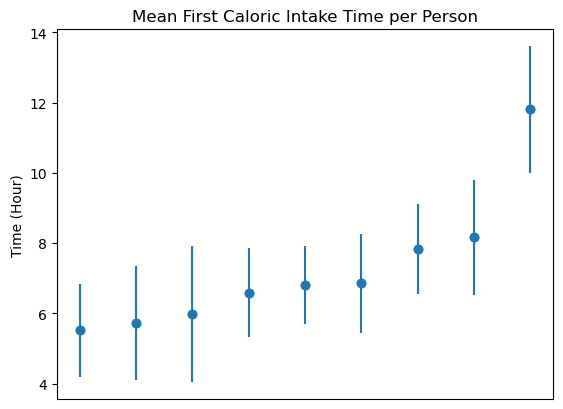

In [ ]:
first_cal_mean_fig = first_cal_mean_with_error_bar('data/output/baseline.json')

In [ ]:
#| export
def last_cal_mean_with_error_bar(data_source:str|pd.DataFrame,
                                 min_log_num:int = 2,
                                 min_separation:int = 4,
                                 identifier:int = 1,
                                 date_col:int = 6,
                                 time_col:int = 7) -> matplotlib.figure.Figure:
    """
    Represents mean and standard deviation of last caloric intake time for each participant
    as a scatter plot, with the x-axis as participants and the y-axis as time (in hours).
    It is recommended that you use find_date and find_float_time to generate necessary date and
    time columns for this function.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. Must have a column for 'food_type' within the data.
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
    
    
    Returns
    -------
    fig
        Matplotlib figure object.
    """
    df = file_loader(data_source)

    # leave only the loggings that are in a good logging day
    df = df[df["food_type"].isin(["f", "b"])]
    df['in_good_logging_day'] = in_good_logging_day(df, min_log_num, min_separation, identifier, date_col, time_col)
    df = df[df['in_good_logging_day']==True]
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]

    first_cal_series = df.groupby([identifier, date_col])[time_col].min()
    

    last_cal_series = df.groupby([identifier, date_col])[time_col].max()
    
    
    # find means and stds for each person
    means = last_cal_series.groupby(identifier).mean().to_frame().rename(columns={'local_time':'mean'})
    stds = last_cal_series.groupby(identifier).std().fillna(0).to_frame().rename(columns={'local_time':'std'})
    
    if means.shape[0] > 50:
        print("More than 50 people are present which might make the graph look messy")
    
    temp = pd.concat([means,stds], axis=1)
    temp.sort_values('mean', inplace=True)
    
    # plot scatter plot with error bars
    plt.scatter(range(temp.shape[0]),temp['mean'])
    plt.errorbar(range(temp.shape[0]), temp['mean'], yerr=temp['std'], fmt="o")
    plt.xticks([])
    plt.ylabel("Time (Hour)")
    plt.title('Mean Last Caloric Intake Time per Person')
    
    fig = plt.gcf()
    
    return fig

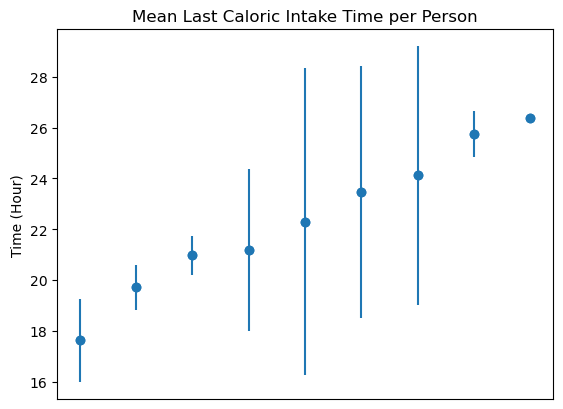

In [ ]:
last_cal_mean_fig = last_cal_mean_with_error_bar('data/output/baseline.json')

In [ ]:
#| export
def first_cal_analysis_variability_plot(data_source:str|pd.DataFrame,
                                        min_log_num:int = 2,
                                        min_separation:int = 4,
                                        identifier:int = 1,
                                        date_col:int = 6,
                                        time_col:int = 7) -> plt.figure.Figure:
    """
    Calculates first caloric log time variability for 'good' logging days by subtracting 5, 10, 25, 50, 75, 90, 95
    percentile of first caloric intake time from the 50th percentile first caloric intake time.
    It also produces a histogram that represents the 90%-10% interval for all participants. It is recommended
    that you use find_date and find_float_time to generate necessary date and time columns for this function.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. Must have a column for 'food_type' within the data.
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
    
    
    Returns
    -------
    fig
        Matplotlib figure object.    
    """
    df = file_loader(data_source)
        
    # leave only the loggings in a good logging day
    df = df[df["food_type"].isin(["f", "b"])]
    df['in_good_logging_day'] = in_good_logging_day(df, min_log_num, min_separation, identifier, date_col, time_col)
    df = df[df['in_good_logging_day']==True]
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    first_cal_series = df.groupby([identifier, date_col])[time_col].min().groupby(identifier).quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    first_cal_df = pd.DataFrame(first_cal_series)
    all_rows = []
    for index in first_cal_df.index:
        tmp_dict = dict(first_cal_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    first_cal_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)
    first_cal_variability_df = first_cal_summary_df.copy()
    
    for col in first_cal_variability_df.columns:
        if col == 'id' or col == '50%':
            continue
        first_cal_variability_df[col] = first_cal_variability_df[col] - first_cal_variability_df['50%']
    first_cal_variability_df['50%'] = first_cal_variability_df['50%'] - first_cal_variability_df['50%']
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    sns_plot = sns.distplot( first_cal_variability_df['90%'] - first_cal_variability_df['10%'] )
    ax.set(xlabel='Variation of First Caloric Intake Time (90% - 10%)', ylabel='Kernel Density Estimation')
    
    return fig

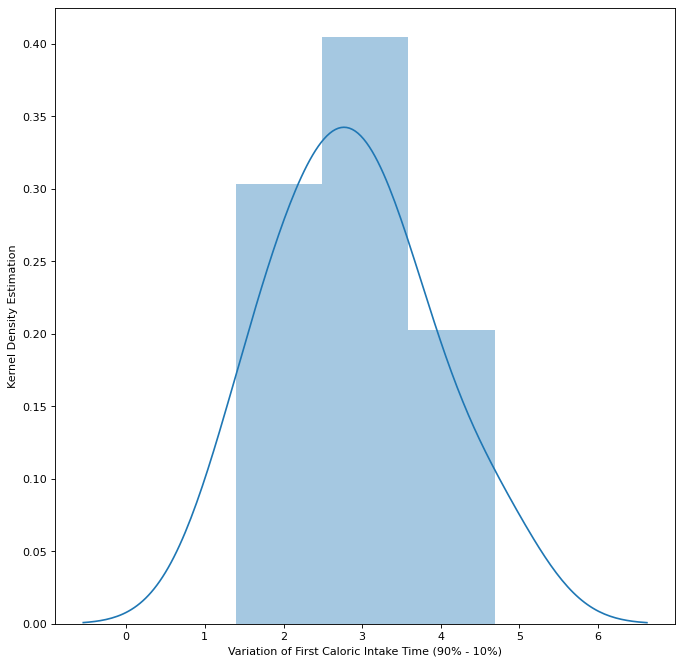

In [ ]:
first_cal_var_plot = first_cal_analysis_variability_plot('data/output/baseline.json')

In [ ]:
#| export
def last_cal_analysis_variability_plot(data_source:str|pd.DataFrame,
                                       min_log_num:int = 2,
                                       min_separation:int = 4,
                                       identifier:int = 1,
                                       date_col:int = 6,
                                       time_col:int = 7) -> plt.figure.Figure:
    """
    Calculates last caloric log time variability for 'good' logging days by subtracting 5, 10, 25, 50, 75, 90, 95
    percentile of last caloric intake time from the 50th percentile last caloric intake time.
    It also produces a histogram that represents the 90%-10% interval for all participants. It is recommended
    that you use find_date and find_float_time to generate necessary date and time columns for this function.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. Must have a column for 'food_type' within the data.
    min_log_num
        Minimum number of logs required for a day to be considered a 'good' logging day.
    min_separation
        Minimum number of hours between first and last log on a log day for it to be considered a 'good' logging day.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
    
    
    Returns
    -------
    fig
        Matplotlib figure object. 
    """
    
    df = file_loader(data_source)
        
    # leave only the loggings that are in a good logging day
    df = df[df["food_type"].isin(["f", "b"])]
    df['in_good_logging_day'] = in_good_logging_day(df, min_log_num, min_separation, identifier, date_col, time_col)
    df = df[df['in_good_logging_day']==True]
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    last_cal_series = df.groupby([identifier, date_col])[time_col].max().groupby(identifier).quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    last_cal_df = pd.DataFrame(last_cal_series)
    all_rows = []
    for index in last_cal_df.index:
        tmp_dict = dict(last_cal_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    last_cal_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)
    last_cal_variability_df = last_cal_summary_df.copy()
    
    for col in last_cal_variability_df.columns:
        if col == 'id' or col == '50%':
            continue
        last_cal_variability_df[col] = last_cal_variability_df[col] - last_cal_variability_df['50%']
    last_cal_variability_df['50%'] = last_cal_variability_df['50%'] - last_cal_variability_df['50%']
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    sns_plot = sns.distplot( last_cal_variability_df['90%'] - last_cal_variability_df['10%'] )
    ax.set(xlabel='Variation of Last Caloric Intake Time (90% - 10%)', ylabel='Kernel Density Estimation')
    
    return fig

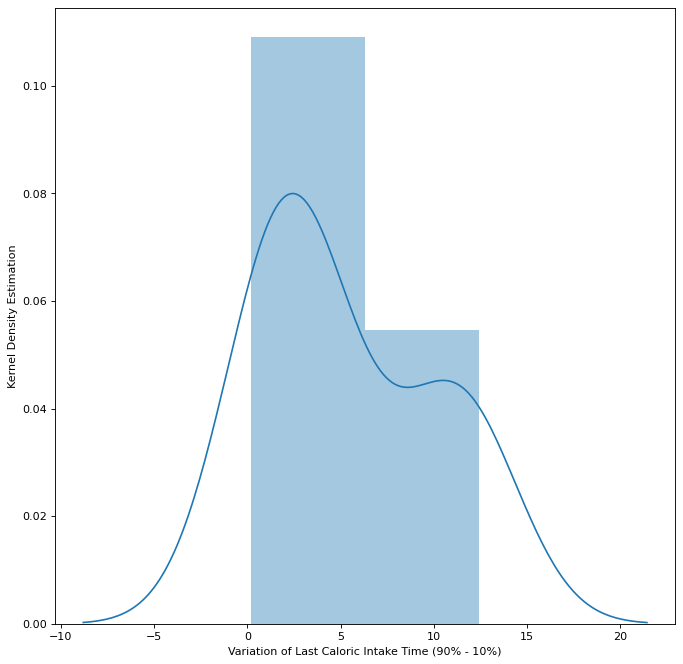

In [ ]:
last_cal_var_plot = last_cal_analysis_variability_plot('data/output/baseline.json')

In [ ]:
#| export
def first_cal_avg_histplot(data_source:str|pd.DataFrame,
                           identifier:int = 1,
                           date_col:int = 6,
                           time_col:int = 7) -> matplotlib.figure.Figure:
    """
    Plots a histogram of average first caloric intake for all participants. It is recommended
    that you use find_date and find_float_time to generate necessary date and time columns for
    this function.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. Must have a column for 'food_type' within the data.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
    
    
    Returns
    -------
    fig
        Matplotlib figure object. 
    """
    df = file_loader(data_source)
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    df = df.query('food_type in ["f", "b"]')
    first_cal_time = df.groupby([identifier, date_col])[time_col].min()
    avg_first_cal_time = first_cal_time.reset_index().groupby(identifier)[time_col].mean()
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    sns.distplot(avg_first_cal_time, kde = False)
    ax.set(xlabel='First Meal Time - Averaged by Person', ylabel='Frequency Count')
    
    return fig

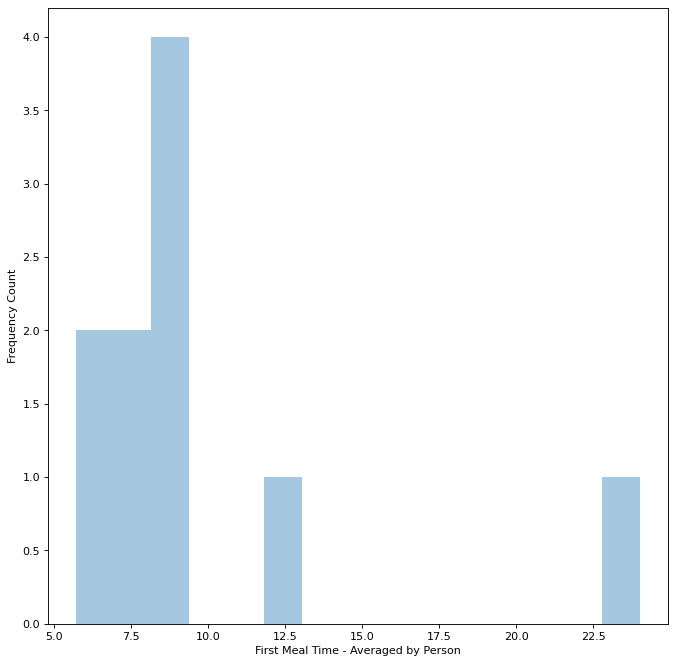

In [ ]:
first_cal_avg_plot = first_cal_avg_histplot('data/output/baseline.json')

In [ ]:
#| export
def first_cal_sample_distplot(data_source:str|pd.DataFrame,
                              n:int,
                              replace:bool = False,
                              identifier:int = 1,
                              date_col:int = 6,
                              time_col:int = 7) -> matplotlib.figure.Figure:
    """
    Creates a distplot for the first caloric intake time for a random selection of 'n' number of 
    participants. It is recommended that you use find_date and find_float_time to generate necessary
    date and time columns for this function.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. Must have a column for 'food_type' within the data.
    n
        Number of participants to plot for, selected randomly without replacement.
    replace
        If true, samples with replacement. Samples without replacement by default.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
    
    
    Returns
    -------
    fig
        Matplotlib figure object. 
    """
    df = file_loader(data_source)
    df = df[df['food_type'].isin(['f','b'])]
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    first_cal_by_person = pd.DataFrame(df.groupby([identifier, date_col])\
                                       [time_col].min())
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    
    print('Plotting distplots for the following users:')
    for i in np.random.choice(np.array(list(set(first_cal_by_person.index.droplevel(date_col)))), n, replace=replace):
        print(i)
        sns.distplot(first_cal_by_person[time_col].loc[i])
    ax.set_xlabel('Time')
    return fig

Plotting distplots for the following users:
alqt8668165687
alqt14018795225
alqt21525720972
alqt45631586569
alqt16675467779


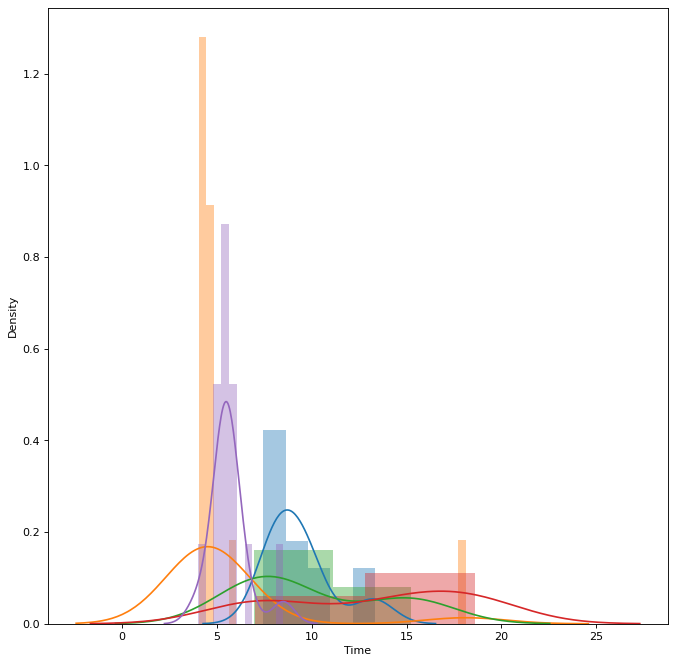

In [ ]:
first_cal_distplot = first_cal_sample_distplot('data/output/intervention.json', n = 5, replace = False)

In [ ]:
#| export
def last_cal_avg_histplot(data_source:str|pd.DataFrame,
                          identifier:int = 1,
                          date_col:int = 6,
                          time_col:int = 7) -> matplotlib.figure.Figure:
    """
    Plots a histogram of average last caloric intake for all participants. It is recommended
    that you use find_date and find_float_time to generate necessary date and time columns for
    this function.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. Must have a column for 'food_type' within the data.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
    
    
    Returns
    -------
    fig
        Matplotlib figure object. 
    """
    df = file_loader(data_source)
    df = df.query('food_type in ["f", "b"]')
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    last_cal_time = df.groupby([identifier, date_col])[time_col].max()
    avg_last_cal_time = last_cal_time.reset_index().groupby(identifier)[time_col].mean()
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    sns.distplot(avg_last_cal_time, kde = False)
    ax.set(xlabel='Last Meal Time - Averaged by Person', ylabel='Frequency Count')
    
    return fig

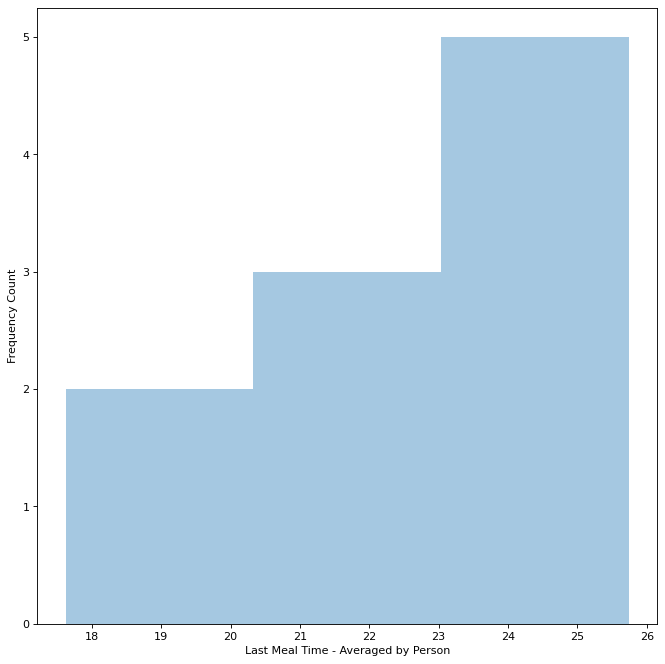

In [ ]:
last_cal_avg_hist = last_cal_avg_histplot('data/output/baseline.json')

In [ ]:
#| export
def last_cal_sample_distplot(data_source:str|pd.DataFrame,
                             n:int,
                             replace:bool = False,
                             identifier:int = 1,
                             date_col:int = 6,
                             time_col:int = 7) -> matplotlib.figure.Figure:
    """
    Creates a distplot for the last caloric intake time for a random selection of 'n' number of 
    participants. It is recommended that you use find_date and find_float_time to generate necessary
    date and time columns for this function.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. Must have a column for 'food_type' within the data.
    n
        Number of participants to plot for, selected randomly without replacement.
    replace
        If true, samples with replacement. Samples without replacement by default.
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
    
    
    Returns
    -------
    fig
        Matplotlib figure object. 
    """
    df = file_loader(data_source)
    df = df[df['food_type'].isin(['f','b'])]
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    last_cal_by_person = pd.DataFrame(df.groupby([identifier, date_col])\
                                       [time_col].max())
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    
    print('Plotting distplots for the following users:')
    for i in np.random.choice(np.array(list(set(last_cal_by_person.index.droplevel(date_col)))), n, replace=replace):
        print(i)
        sns.distplot(last_cal_by_person[time_col].loc[i])
    ax.set_xlabel("Time")
    
    return fig

Plotting distplots for the following users:
alqt14018795225
alqt8668165687
alqt21525720972
alqt16675467779
alqt45631586569


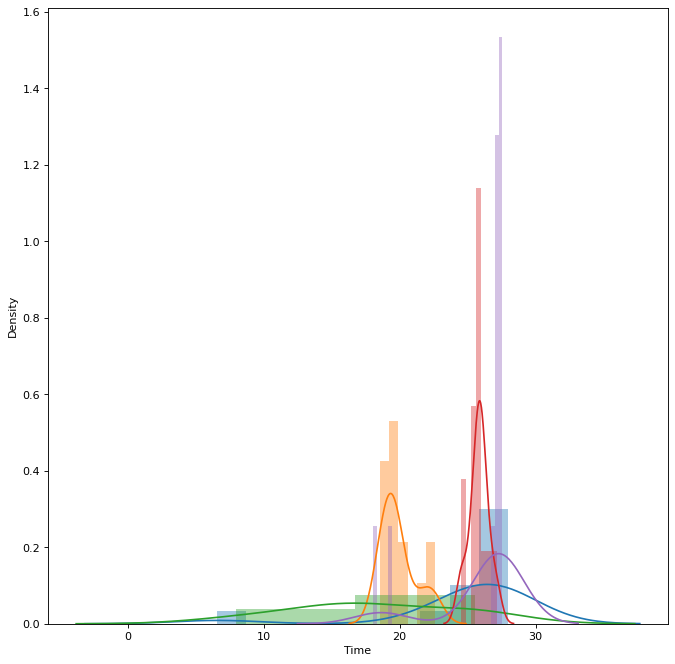

In [ ]:
last_cal_distplot = last_cal_sample_distplot('data/output/intervention.json', n = 5, replace=False)

In [ ]:
#| export
def swarmplot(data_source:str|pd.DataFrame,
              max_loggings:int,
              identifier:int = 1,
              date_col:int = 6,
              time_col:int = 7) -> matplotlib.figure.Figure:
    """
    Creates a swarmplot for participants logging data. It is recommended that you
    use find_date and find_float_time to generate necessary date and time columns for
    this function.
    
    Parameters
    ----------
    data_source
        String file or folder path. Single .json or .csv paths create a pd.DataFrame. 
        Folder paths with files matching the input pattern are read together into a single pd.DataFrame. Existing
        dataframes are read as is. Must have a column for 'food_type' within the data.
    max_loggings
        Maximum number of randomly selected logs to be plotted for each participant. 
    identifier
        Column number for an existing unique identifier column in provided data source. Data exported from mCC typically
        has a unique identifier as its 1st column.
    date_col
        Column number for an existing date column in provided data source. 
    time_col
        Column number for an existing time column in provided data source.
        
        
    Returns
    -------
    fig
        Matplotlib figure object.
    """
    
    df = file_loader(data_source)
    
    identifier = df.columns[identifier]
    # if treets functions have been used (in any order) to generate columns
    # find appropriate column names, if not check for expected column position
    if 'date' in df.columns:
        date_col = df.columns[df.columns.get_loc('date')]
    else:
        date_col = df.columns[date_col]
        
    if 'float_time' in df.columns:
        time_col = df.columns[df.columns.get_loc('float_time')]
    else:
        time_col = df.columns[time_col]
    
    def subsamp_by_cond(alldat):
        alld = []
        for apart in alldat[identifier].unique():
            dat = alldat[alldat[identifier]==apart]
            f_n_b = dat.query('food_type in ["f", "b"]')
            n = min([f_n_b.shape[0], max_loggings])
            sub = f_n_b.sample(n = n, axis=0)
            alld.append(sub)
        return pd.concat(alld)

    sample = subsamp_by_cond(df)
    fig, ax = plt.subplots(1, 1, figsize = (10, 30), dpi=300)


    ax.axvspan(3.5,6, alpha=0.2, color=[0.8, 0.8, 0.8]  )
    ax.axvspan(18,28.5, alpha=0.2, color=[0.8, 0.8, 0.8]  )
    # plt.xlabel('Hour of day')
    plt.xticks([4,8,12,16,20,24,28],[4,8,12,16,20,24,4])
    plt.title('Caloric Events for TRE Group')

    ax = sns.swarmplot(data = sample, 
                  y = identifier, 
                  x = time_col, 
                  dodge = True, 
                  color = sns.xkcd_rgb['golden rod'],
                 )

    ax.set(
        facecolor = 'white', 
        title = 'Caloric Events',
        ylabel = 'Participant',
        xlabel = 'Local Time'
    )
    
    return fig

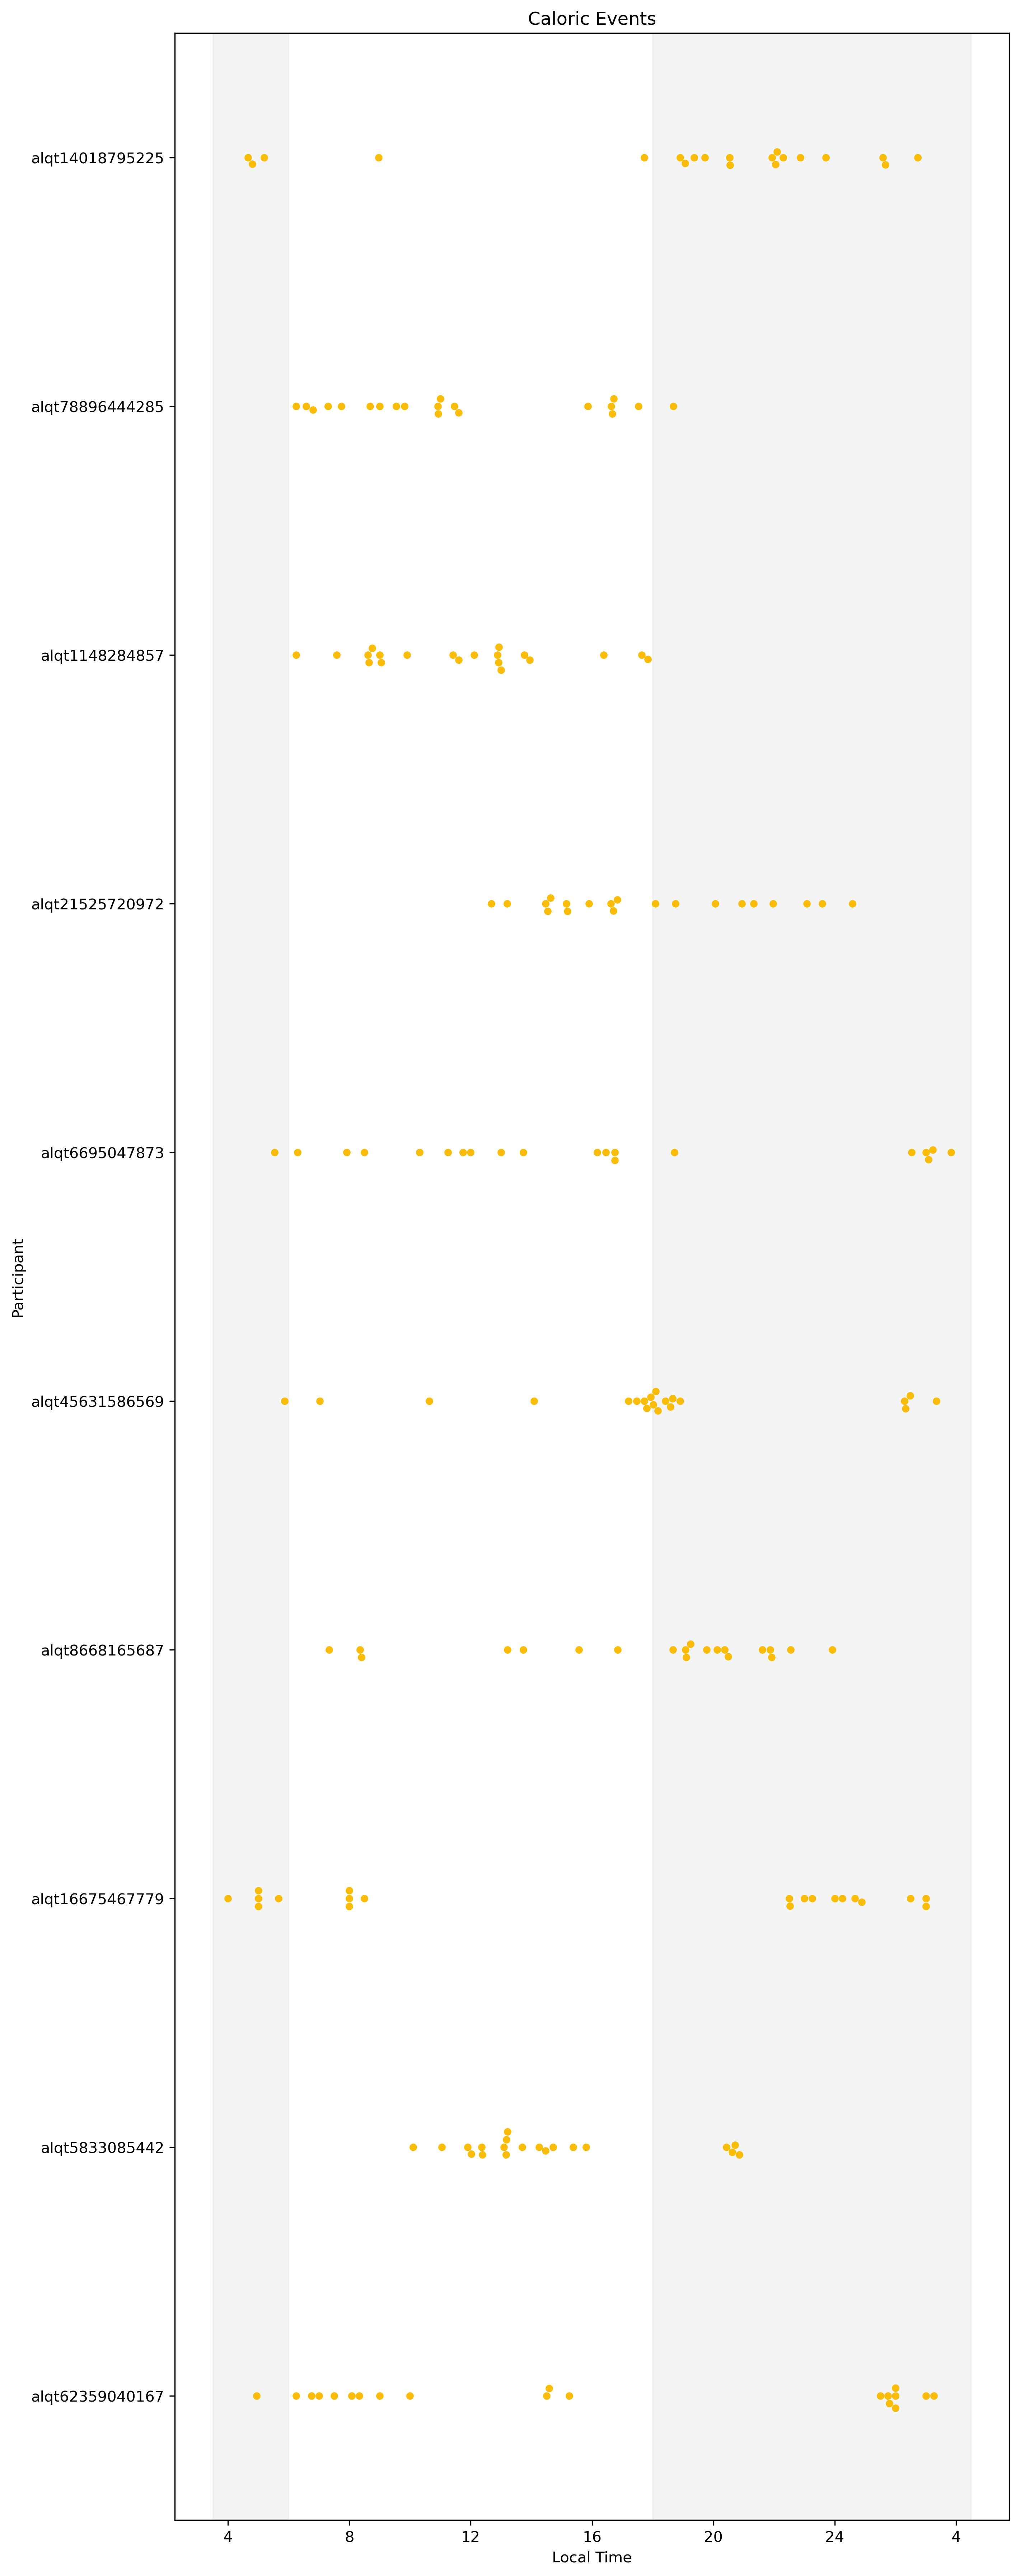

In [ ]:
swarm = swarmplot('data/output/public.json', max_loggings = 20)